In [341]:
#Import Libraries
import importlib
import pip
def import_or_install(packages):
    for package, value in packages.items():
        try:
            imported_package = importlib.import_module(package)
            if isinstance(value, str):
                globals()[value] = imported_package
            elif isinstance(value, dict):
                for func, alias in value.items():
                    globals()[alias] = getattr(imported_package, func)
        except ImportError:
            pip.main(['install', package])
            imported_package = importlib.import_module(package)
            if isinstance(value, str):
                globals()[value] = imported_package
            elif isinstance(value, dict):
                for func, alias in value.items():
                    globals()[alias] = getattr(imported_package, func)

save_mode = False #Change to False to reduce demand, True to save all figures
from matplotlib import pyplot as plt
#Libraries
libraries = {'openpyxl':'openpyxl',
             'pandas':'pd',
             'numpy':'np',
             'matplotlib':None,
             'matplotlib': {'pyplot':'plt'},
             'seaborn':'sns',
             'scipy':{'stats':'stats'},
             'stats':{'ttest_ind_from_stats'},
             'math':{'log10':'log10', 'floor':'floor'},
             'warnings':'warnings',
             'functools':'functools',
             'functools':{'reduce':'reduce'},
             'os':'os',
             'time':'time',
             'logging':'logging'}


import_or_install(libraries)
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.DEBUG)

warnings.filterwarnings('ignore')
directory = 'C:/Users/Owner/OneDrive - Imperial College London' #Set Main file directory
if (not os.path.exists(directory)):
    directory = 'c:/Users/jm3923/OneDrive - Imperial College London'
if (not os.path.exists(directory)):
    directory = 'C:/Users/jamie/OneDrive - Imperial College London'
#Set label names
AB = 'Aβ'
CK = 'CK1δ'
hAPP = 'hAPPᵂᵀ'
NLGF = 'hAPPᴺᴸᴳf'

#Define hex colors to be used in project"    
colors = {'red':'#FF5757', 
          'dark_red':'#780000',
          'orange':'#ff8400',
            'blue':'#83FFFA',
            'dark_blue':'#03358c', 
            'green':'#8FFF83',
            'dark_green':'#176601',
            'yellow':'#FFFB83',
            'dark_yellow':'#8f8f01',
            'grey': '#808080',
            'black':'#000000',
            'purple': '#4d0254'}

#Generate Blend Palettes based on all colors, access with "palettes['color-color']"
palettes = {} 
for key1,item1 in colors.items():
    for key2,item2 in colors.items():
        palettes[f'{key1}-{key2}'] = f'blend:{item1},{item2}'
#print(palettes)

In [ ]:
#Classes
def location_tick_params(location_ax): 
    #Removes all frames and allows ax to be directly next to eachother
    location_ax.tick_params(axis='both',which='both',bottom=False, top=False,left=False, right=False,labelbottom=False,labelleft=False) 
    location_ax.set_xlim(xmin=500, xmax=0)
    location_ax.set_ylim(ymin=0, ymax=800)  
    location_ax.legend().set_visible(False)
    location_ax.set_facecolor('black')
    location_ax.spines['right'].set_color('white')
    location_ax.spines['right'].set_linewidth(1.5)
    location_ax.spines['top'].set_color('white')
    location_ax.spines['top'].set_linewidth(1)
    location_ax.set(ylabel=None, xlabel=None)

time_dict = {}
def runtime(func):
    def wrap(self, *args):
        global time_dict
        start_time = time.time()
        func(self, *args)
        end_time = time.time()
        run_time = end_time - start_time
        if f'{func.__name__}' in time_dict.keys():
            time_dict[f'{func.__name__}'] += run_time
        else:
            time_dict[f'{func.__name__}'] = run_time
    return wrap


threshold = 90
def flatten(xss):
    #Flatten multi-dimensional list
    return [x for xs in xss for x in xs]

def remove_none(data):
    data = [x for x in data if x is not None]
    return data

class Experiment:
    def __init__(self, name, cellMarkers, objectMarkers, colocData, otherStains, stainColors, behaviour, otherAttributes, labels, filePath):
        self.name = name #title of experiment
        self.cellMarkers = cellMarkers #only intracellular objects with no colocalisation data
        self.objectMarkers = objectMarkers #intra or extracellular objects with colocalisation data
        self.colocData = colocData #Dictionary of all objects as keys with list of colocalisation dataframes as values
        self.otherStains = otherStains #non-object stains (e.g GFAP)
        self.stainColors = stainColors
        self.behaviour = behaviour
        self.otherAttributes = otherAttributes
        self.labels = labels #List of animal names for each SCN data
        self.filePath = filePath #File path that describes location beyond main directory
        self.classList = [cellMarker, objectMarker, Antibody, Attribute]

    def set_condition_list(self, condition_list):
        self.condition_list = condition_list
        self.factor_list = condition_list.factor_list
        primary = condition_list
        for factor in reversed(self.factor_list):
            names = [cond.name for cond in primary.conditions_list]
            names = '|'.join(names)
            self.Summary[factor] = self.Summary['Condition'].str.extract(f'({names})', expand=False)
            primary = primary.primary
        return self.condition_list

    def import_coloc_csvs(self):
        self.colocDFs = self.colocData.copy()
        for object in self.colocData.keys(): #Iterate through list of objects with colocalisation data
            valueList = [pd.read_csv(self.filePath + f"/{object} Colocalisation with {object_colocaliser}.csv") for object_colocaliser in self.colocData[object]] #Import csvs for each colocalisation data for that object
            self.colocDFs[object] = valueList #Replace list of filenames with actual dataframes
        print('Colocalisation data imported')
        return self.colocDFs

    @runtime   
    def import_attribute_csvs(self):
        self.data = {}
        for i,lst in enumerate([self.cellMarkers, self.objectMarkers, self.otherStains, self.otherAttributes]):
            for key in lst:
                if key != None:
                    attribute_list = [pd.read_csv(self.filePath + f"/{key}.csv"), self, key]
                    [attribute_list.append(attribute[key]) for attribute in [self.stainColors,self.colocDFs] if key in attribute] 
                    attribute_class = self.classList[i] if i < len(self.classList) else self.classList[-1]
                    self.data[key] = attribute_class(*attribute_list)
                    print(f'{key} added to class {self.data[key].__class__.__name__}')
        return self.data
              
    @runtime            
    def create_SCN_animal_list(self): 
        #Add SCN labels to each animal name
        self.labels = pd.read_csv(self.filePath + f"/{self.labels[0]}.csv")
        self.labels.index.names = ['SCN']
        self.labels.index += 1
        return self.labels 

    def __repr__(self): #Returns experiment string when using 'print(experiment)'
        self.experimentString = f"""{self.name} included the animals {self.labels['Animal Name'].unique()}.
        The behaviours {self.data['Behaviour'].df.columns} were measured.
        The cell markers {remove_none(self.cellMarkers)}, object markers {remove_none(self.objectMarkers)}, and other stains {remove_none(self.otherStains)} were used.
        """
        return self.experimentString
    
    @runtime
    def process_data(self):
        print(f'Beginning Data Processing for {self.name}!\n_______________________________________________')
        self.create_SCN_animal_list()
        self.import_coloc_csvs()
        self.import_attribute_csvs()
        self.get_volume()
        self.create_summary()
        #self.add_other_attributes()
        processes = []
        for object1 in self.data.values():
            for object2 in self.data.values():
                if (isinstance(object1, cellMarker) or isinstance(object1, objectMarker)) and \
                    (isinstance(object2, cellMarker) or isinstance(object2, objectMarker)) and \
                    object1 != object2:
                        object1.find_closest_distances_between_markers(object2)
        global time_dict
        print(dict(sorted(time_dict.items(), key=lambda item: item[1], reverse=True)))
        time_dict = {}
        for p in processes:
            p.start()
        for p in processes:
            p.join()

    @runtime
    def get_volume(self):
        try:
            volume = self.data['Area'].df
            volume['SCN Volume'] = volume['Area'] * 12
        except KeyError:
            volume = pd.DataFrame({'SCN Volume': [(290.91**2)*12] * len(self.labels)})
            volume.index.name = 'SCN'
            volume.index += 1
            volume = volume.reset_index()
            self.data['Area'] = Attribute([], self, 'Area')
        volume['SCN'] = [i+1 for i in range(volume['SCN Volume'].count())]
        volume = volume.merge(self.labels, left_on='SCN', right_on='SCN')
        volume = volume[['SCN', 'Animal Name', 'SCN Volume']]
        self.data['Area'].df = volume
        return self.data
    
    @runtime
    def create_summary(self):
        summary_dfs = []
        data = self.data.values()
        df_list = []
        antibody_list = []
        to_drop = ['SCN', 'Animal Name', 'Condition', 'Volume', 'Label']
        print(df_list)

        for stain_df in data: #Iterate through each df and separate columns into columns to mean and columns to sum
            stain_df = stain_df.df
            
            mean_columns = stain_df.filter(regex='^(?!.*Count).*').columns.tolist() #Use regex to select columns not containing 'Count'
            mean_columns = [m for m in mean_columns if not(any(d in m for d in to_drop))]              
            mean_df = stain_df.groupby('Animal Name')[mean_columns].mean()
                
            count_columns = stain_df.filter(regex='Count').columns.tolist() #Use regex to select columns containing 'Count'
            count_df = stain_df[count_columns] #Reinstance dataframe to only include columns to sum
            count_df = count_df.applymap(lambda x: 1 if x > 1 else x) #Convert all counts to 1
            count_df['Animal Name'] = stain_df['Animal Name'] #Add animal Name column
            count_df = count_df.groupby('Animal Name')[count_columns].sum() #Group data by Animal Names
                
            summary_dfs.append(mean_df)
            summary_dfs.append(count_df) #List of all dataframes to be combined
        
        self.Summary = reduce(lambda left, right: pd.merge(left, right, left_on='Animal Name', right_on='Animal Name'), summary_dfs) #Combine dfs
        self.Summary = self.Summary.merge(self.data['Area'].df.groupby('Animal Name').mean(), left_on='Animal Name', right_on='Animal Name') #Combine SCN volume
        self.Summary['Condition'] = [''.join(filter(str.isalpha, name)) for name in self.Summary.index.to_list()]

        #Adjust Count columns based on number of sections to get mean
        self.Summary['SCN Sections'] = self.labels['Animal Name'].value_counts() #Get number of sections
        count_columns = [col for col in self.Summary.columns if 'Count' in col] #Identify Count columns
        self.Summary[count_columns] = self.Summary[count_columns].div(self.Summary['SCN Sections'], axis=0) #Divide Count columns by number of sections

        #Adjust for Volume
        columns_to_adjust = ['Count', 'IntDen']
        for column in self.Summary.columns.tolist():
            if any(c in column for c in columns_to_adjust) and ('Mean' not in column):
                denominator = '1 micron³'
                if 'IntDen' in column:
                    replacement = 'Integrated Density'
                    if 'Total' not in column:
                        replacement = 'Total Particle Integrated Density'
                    new_column_name = f'{column} / {denominator}'.replace('IntDen', replacement)
                if 'Count' in column :
                    denominator = '1000000 microns³'
                    new_column_name = f'{column} / {denominator}'
                self.Summary[column] = self.Summary[column] / (self.Summary['SCN Volume'] / int(denominator.split(' ')[0])) 
                self.Summary.rename(columns={column: new_column_name.replace(' 1 ', ' ')}, inplace=True)
            if 'Mean IntDen' in column:
                self.Summary.rename(columns={column: column.replace('IntDen', 'Particle Integrated Density')}, inplace=True) 

        #Add behaviour data to summary if provided
        try:
            self.Summary = self.Summary.merge(self.data['Behaviour'].df, left_on = 'Animal Name', right_on='Animal Name') 
        except KeyError as k:
            print("No behaviour data to include")

        print(f'{self.name} data combined into a summary with the following columns: {self.Summary.columns.tolist()}\n________________________________________________')
        return self.Summary
    
class Attribute:
    def __init__(self, df, experiment, name):
        self.df = df #Each attribute has its own dataframe
        self.experiment = experiment #Associate each attribute with a particular experiment to access all of the experiments' attributes
        self.name = name

class Antibody(Attribute):
    def __init__(self, df, experiment, name, color=None):
        super().__init__(df, experiment, name) #Set all of 'Attribute' class __init__
        self.name = name #Name of antibody for labels
        self.color = color
        self.df = self.clean_df()

    @runtime    
    def map_SCN_animal_name(self):
        #Add SCN and animal name label 
        self.df = self.df.replace(np.NaN,0) #Replace NaN with 0
        SCN = 0 #Initialise first SCN label
        self.df['SCN'] = (self.df['Count'].isin([0, 1])).cumsum() #Initialise SCN column label
        self.df = self.df.merge(self.experiment.labels, left_on='SCN', right_on='SCN') #Merge SCN-labelled dataframe with animal names
        self.df.columns = [f'{self.name} {col_name}' for col_name in self.df.columns] #Add specific labels for antibody to each column
        self.df = self.df.replace(np.NaN, 0) #Replace NaN with 0
        return self.df
    
    @runtime
    def clean_df_and_add_columns(self):
        #Change column names etc
        name = self.name
        self.df[f'{name} Volume'] = self.df[[f'{name} Volume (micron^3)']]
        self.df[f'{name} Mean IntDen'] = self.df[f'{name} Mean']
        self.df[f'{name} IntDen'] = self.df[f'{name} IntDen']
        self.df[f'{name} Condition'] = [''.join(filter(str.isalpha, name)) for name in self.df[f'{name} Animal Name']]
        self.df[f'{name} Surface Area:Volume Ratio'] = self.df[f'{name} Surface (micron^2)']/self.df[f'{name} Volume']
        self.df = self.df[[f'{name} SCN', f'{name} Animal Name', f'{name} Condition', f'{name} Count', f'{name} Volume', f'{name} IntDen', f'{name} Mean IntDen', f'{name} Surface Area:Volume Ratio', f'{name} XM', f'{name} YM', f'{name} ZM']]
        print(f'{name} data cleaned')
        return self.df
    
    def clean_df_and_add_columns_simple(self):
        name = self.name
        self.df[f'{name} Condition'] = [''.join(filter(str.isalpha, name)) for name in self.df[f'{name} Animal Name']]
        self.df.rename(columns={f'{self.name} SCN': 'SCN', f'{self.name} Animal Name': 'Animal Name', f'{self.name} Condition': 'Condition'}, inplace=True)
        return self.df
    
    @runtime
    def adjust_coordinates(self,):
        name = self.name
        self.df[f'{name} Raw XM'] = self.df[f'{name} XM']
        self.df[f'{name} Raw YM'] = self.df[f'{name} YM']
        try:
            area = self.experiment.data['Area']
            area['SCN'] = [i+1 for i in range(area['Label'].count())]
            self.df = self.df.merge(area, left_on=f'{name} SCN', right_on='SCN')
            self.df['Width'] = [int(label.split('.')[1]) for label in self.df['Label']]
            self.df['Height'] = [int(label.split('.')[2].split(':')[0]) for label in self.df['Label']]
            self.df['X_factor'] = 800/self.df['Width']
            self.df['Y_factor'] = 500/self.df['Height']
            self.df[f'{name} XM'] = self.df[f'{name} XM'] * self.df['X_factor']
            self.df[f'{name} YM'] = self.df[f'{name} YM'] * self.df['Y_factor']
        except KeyError as k: toprint = 'No Area Data provided; coordinates not adjusted'
        else: toprint = f'{name} adjusted coordinates added'
        finally:
            self.df = self.df[self.df.columns.drop(list(self.df.filter(regex=f'^(?!.*{name}).*')))]
            self.df.rename(columns={f'{self.name} SCN': 'SCN', f'{self.name} Animal Name': 'Animal Name', f'{self.name} Condition': 'Condition'}, inplace=True)
            print(toprint)
        return self.df
    
    @runtime
    def add_all_attributes(self):
        self.df = self.df.merge(self.experiment.Summary, left_on='Animal Name', right_on='Animal Name')
        return self.df

    def set_df(self, new_df):
        self.df = new_df
        return self.df
    
    def clean_df(self):
        #Perform all functions required to fully clean dataframe wihtout need for user input
        try:
            self.map_SCN_animal_name()
        except: pass
        try:
            self.clean_df_and_add_columns_simple()
        except: pass
        #self.adjust_coordinates()
        try:
            self.df.set_index('SCN', inplace=True)
        except: pass
        print(f'{self.name} data processing successfully completed!\n________________________________________')
        return self.df  

    @runtime
    def find_closest_distances_between_markers(self, other_marker):
        #Iterate through all of self and find closest otherMarker point in Euclidian distance
        other_marker_df = other_marker.df
        #Convert points to numpy array which will speed up runtime processing
        all_distances = []
        all_colocalised = []

        #Iterate through SCNs
        for s in self.df.index.unique():
            #Create new isolated SCN dataframe instances
            SCN_df_self = self.df[self.df.index == s]
            SCN_df_other = other_marker_df[other_marker_df.index == s]
            
            if SCN_df_self.empty or SCN_df_other.empty or SCN_df_self[f'{self.name} ZM'].iloc[0] == 0:
                    closest_distance = np.full(SCN_df_self.shape[0], np.inf)
                    colocalised_array = np.zeros(SCN_df_other.shape[0])
            else:
                # Extract coordinates as numpy arrays
                self_coords = SCN_df_self[[f'{self.name} XM', f'{self.name} YM', f'{self.name} ZM']].to_numpy()
                other_coords = SCN_df_other[[f'{other_marker.name} XM', f'{other_marker.name} YM', f'{other_marker.name} ZM']].to_numpy()

                # Compute distances
                distances = np.linalg.norm(self_coords[:, np.newaxis] - other_coords, axis=2)
                closest_distance = np.min(distances, axis=1)

                closest_other_indices = np.argmin(distances, axis=1)
                colocalised_array = np.zeros(SCN_df_other.shape[0])
                try:
                    colocalised_array[closest_other_indices] = np.where(SCN_df_self[f'{self.name} %Colocalisation with {other_marker.name}'] > 90, 2, 1) if SCN_df_other[f'{other_marker.name} ZM'].iloc[0] != 0 else 0
                except KeyError:
                    colocalised_array[closest_other_indices] = 1 if SCN_df_other[f'{other_marker.name} ZM'].iloc[0] != 0 else 0

            all_distances.extend(closest_distance)
            all_colocalised.extend(colocalised_array)

        self.df[f'Distance to closest {other_marker.name}'] = all_distances
        other_marker_df[f'Closest to {self.name}'] = all_colocalised

        other_marker.set_df(other_marker_df)

        print(f"'Closest to {self.name}' column added to {other_marker.name} DataFrame!")
        print(f"'Distance to closest {other_marker.name}' column added to {self.name} DataFrame!")
            
        return self.df

class cellMarker(Antibody): 
    #only intracellular objects with no colocalisation data
    def __init__(self, df, experiment, name, color):
        self.df = df
        self.experiment = experiment
        self.name = name
        self.color = color
        self.df = self.clean_df()

    def clean_df(self):
        super().map_SCN_animal_name() #function from antibody class
        super().clean_df_and_add_columns()
        super().adjust_coordinates()
        self.df.set_index('SCN', inplace=True)
        print(f'{self.name} data processing successfully completed!\n________________________________________')
        return self.df

class objectMarker(Antibody):
    #intra or extracellular objects with colocalisation data
    def __init__(self, df, experiment, name, color, coloc, threshold=90):
        self.df = df
        self.experiment = experiment
        self.name = name
        self.color = color
        self.coloc = coloc #List of Colocalisation dataframes of object with other object or cell marker
        self.threshold = threshold #Threshold for determining whether object and colocalised are colocalised
        self.df = self.clean_df()
    
    @runtime
    def add_coloc_data(self, threshold):
        #Add column of percentage colocalisation to object dataframe
        for i,coloc_data in enumerate(self.coloc):
            colocaliser = self.experiment.colocData[self.name][i]
            try:
                coloc_data.drop(coloc_data[coloc_data.LabelObj == 255].index, inplace=True) #255 is unncessary value
                coloc_data = coloc_data.reset_index()
                self.df = self.df.join(coloc_data['P1']) #Join object dataframe to P1 column, which is percentage colocalisation column
                self.df[f'{self.name} %Colocalisation with {colocaliser}'] = self.df['P1'] #Rename colocalisation column
                self.df[f'{self.name} {colocaliser}-Colocalised Count'] = np.where(self.df[f'{self.name} %Colocalisation with {colocaliser}'] > threshold, 1, 0) #Add column of counts of colocalised objects
                self.df[f'{self.name} {colocaliser}-Non Colocalised Count'] = np.where(self.df[f'{self.name} %Colocalisation with {colocaliser}'] < threshold, 1, 0) #Add column of counts of non-colocalised objects
                self.df = self.df.drop(columns=['P1'])
                self.df = self.df.replace(np.NaN, 0)
            except: pass
        return self.df
    
    @runtime
    def set_coloc_dfs(self):
        pass

    def clean_df(self):
        #Perform all functions required to fully clean dataframe
        #Functions from antibody class
        super().map_SCN_animal_name() 
        super().clean_df_and_add_columns()
        super().adjust_coordinates()
        self.add_coloc_data(threshold)
        self.df.set_index('SCN', inplace=True)
        print(f'{self.name} data processing successfully completed!\n_____________________________________________________')
        return self.df

class condition:
    def __init__(self, label, name, color):
        self.label = label
        self.name = name
        self.color = color

class condition_list_wrapper:
    def __init__(self, primary, secondary):
        self.primary = primary #Condition list to be wrapped
        self.secondary = secondary #Dataframe names
        self.conditions_list = secondary.conditions_list
        self.factor_list = primary.factor_list
        self.factor_list.append(secondary.factor_list[0])
        self.total = self.wrap_conditions()

    def wrap_conditions(self):
        #Create new list of conditions with extra conditions added onto each of the old conditions e.g Genotype + Drug/Vehicle
        new_condition_list = [] #Initialise empty new condition list
        for wrapped_cond in self.primary.conditions_list: #Iterate through each condition to be wrapped
            for wrapper_cond in self.conditions_list: #Iterate through each new condition to be added on
                #Adjust new attributes for each new condition
                new_label = wrapped_cond.label + f' + {wrapper_cond.label}'
                new_name = wrapped_cond.name + f'{wrapper_cond.name}'
                new_color = wrapped_cond.color if wrapper_cond.color is None else wrapper_cond.color
                new_condition_list.append(condition(new_label, new_name, new_color)) #Create new condition with everything added and add to new condition list
                print(new_label, new_name, new_color)      
        return new_condition_list
    
class condition_list:
    def __init__(self, conditions_list, factor, primary=None):
        self.conditions_list = conditions_list #List of condition objects
        self.total = conditions_list
        self.factor = factor #Names of the condition e.g 'Genotype'
        self.factor_list = [factor]
        self.primary = primary

##First round of experiment conditions
Syn = condition('Syn-mCherry', 'Syn', 'grey')
hAPP = condition('hAPPᵂᵀ', 'hAPP', colors['blue'])
NLGF = condition('hAPPᴺᴸᴳꟳ', 'NLGF', colors['red'])
genotype_condition_list = condition_list([Syn, hAPP, NLGF], 'Genotype') 


In [ ]:
#Define new experiments
def new_experiment(exp_dict):
    new_experiment = Experiment(exp_dict['name'], exp_dict['cellMarkers'], exp_dict['objectMarkers'], exp_dict['colocData'], exp_dict['otherStains'], exp_dict['stainColors'], exp_dict['behaviour'], exp_dict['otherAttributes'], exp_dict['labels'], directory+exp_dict['filePath'],)
    return new_experiment 

#Combine experiments into a summary
class Batch:
    def __init__(self, experiment_list, cond_list):
        self.experiment_list = experiment_list
        self.condition_list = cond_list
        self._current = 0

    def process_data(self):
        [exp.process_data() for exp in self.experiment_list]
        [exp.set_condition_list(self.condition_list) for exp in self.experiment_list]

    def create_batch_summary(self):
        summaries = [exp.Summary for exp in self.experiment_list]
        names = [exp.name for exp in self.experiment_list]
        #for i,summary in enumerate(summaries):
            #summary.columns = [f'{column}_{names[i]}' for column in summary.columns]
        #print(summaries[0])
        #summaries = [summary.reset_index() for summary in summaries]
        #summaries[0].set_index('Animal Name', inplace=True)
        self.Summary = reduce(lambda left, right: pd.merge(left, right, on='Animal Name', how='outer', suffixes=('','_')), summaries)
        #self.Summary['Condition'] = [''.join(filter(str.isalpha, name)) for name in self.Summary.index]
        return self.Summary
    
    def __iter__(self):
        self._current = 0
        return self
    
    def __next__(self):
        if self._current < len(self.experiment_list):
            experiment = self.experiment_list[self._current]
            self._current += 1
            return experiment
        else:
            raise StopIteration
        
exp1_dict = {
    'name':'Experiment 1',
    'cellMarkers':['DAPI'],
    'objectMarkers':['H31L21', 'mCherry'],
    'colocData':{'H31L21':['mCherry', 'DAPI'], 'mCherry':['H31L21', 'DAPI']},
    'otherStains':[None],
    'stainColors':{'DAPI':'blue', 'mCherry':'red', 'H31L21':'green'},
    'behaviour':['Behaviour'], 
    'otherAttributes':['Area', 'Batch'],
    'labels': ['Labels'], 
    'filePath':'/IHF Pipeline/Example Data'
}

exp2_dict = {
    'name':'Experiment 2',
    'cellMarkers':['DAPI', 'mCherry'],
    'objectMarkers':['MOAB-2', 'CK1δ'],
    'colocData':{'MOAB-2':['mCherry'], 'CK1δ':['mCherry']},
    'otherStains':[None],
    'stainColors':{'DAPI':'blue', 'mCherry':'red', 'MOAB-2':'green', 'CK1δ':'yellow'},
    'behaviour':[None], 
    'otherAttributes':['Area', 'Batch'],
    'labels': ['Labels'], 
    'filePath':'/IHF Pipeline/Example Data'  
}

exp3_dict = {
    'name':'Experiment 3',
    'cellMarkers':['DAPI', 'mCherry'],
    'objectMarkers':['AT8'],
    'colocData':{'AT8':['mCherry']},
    'otherStains':['GFAP'],
    'stainColors':{'DAPI':'blue', 'mCherry':'red', 'AT8':'green', 'GFAP':'magenta'},
    'behaviour':[None], 
    'otherAttributes':['Batch'],
    'labels': ['Labels'], 
    'filePath':'/IHF Pipeline/Example Data'  
}

exp4_dict = {
    'name':'Experiment 4',
    'cellMarkers':['Iba1'],
    'objectMarkers':['MOAB-2', 'H31L21', 'mCherry'],
    'colocData':{'MOAB-2':['mCherry', 'Iba1', 'H31L21'], 'H31L21':['mCherry', 'Iba1', 'MOAB-2'], 'mCherry':['Iba1', 'MOAB-2', 'H31L21']},
    'otherStains':['Iba1 Total'],
    'stainColors':{'Iba1':'magenta', 'mCherry':'red', 'MOAB-2':'green', 'H31L21':'yellow'},
    'behaviour':['Behaviour'], 
    'otherAttributes':['Batch'],
    'labels': ['Labels'], 
    'filePath':'/IHF Pipeline/Example Data' 
}

exp1 = new_experiment(exp1_dict)
exp2 = new_experiment(exp2_dict)
exp3 = new_experiment(exp3_dict)
exp4 = new_experiment(exp4_dict)
First_Round = Batch([exp1, exp2, exp3, exp4], genotype_condition_list)
First_Round.process_data()
First_Round.create_batch_summary()

In [89]:
First_Round.Summary.to_csv(directory + '/IHF Pipeline/Example Data/First_Round.csv')
First_Round_csv = pd.read_csv(directory + '/IHF Pipeline/Example Data')

In [392]:
#STATS
from scipy.stats import f_oneway, tukey_hsd
#%pip install scikit_posthocs
import scikit_posthocs as sp
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr
import scipy

def get_annotation(p, ns='ns'):
    #Determine number of stars based on level of significance
    annotation = '*' if 0.01 < p < 0.05 else '**' if 0.001 < p < 0.01 else '***' if 0.0001 < p < 0.001 else '****' if 0 < p < 0.0001 else ns
    return annotation

def test_normality(df_list):
    #Initialise variable to establish which test to run
    normality = 'Normal'

    #Iterate through dfs and test for normality
    for df in df_list:
        statistic, pvalue = stats.shapiro(df)

        #Run Kruskal if not normal
        if pvalue < 0.05:
            normality = 'Not Normal'
    return normality, statistic, pvalue


def compare_adjacent_bars(data_list,ax,x_factor=0,pad=10,handles_fraction=0.3):
    #Runs normality test followed by appropriate comparison test (Indpendent student t-test if normal, or Wilcoxon if not)
    for i in range(int(len(data_list)/2)):
        exp1_data = data_list[i*2]
        exp2_data = data_list[(i*2)+1]
        normality = 'Normal'
        for data in [exp1_data, exp2_data]:
            s, p = stats.shapiro(data)
            if p < 0.05:
                normality = 'Not Normal'
        if normality == 'Not Normal':    
            stat, pvalue = runmannwhitneyu(exp1_data, exp2_data)
            test = 'ManWhitneyU'
        else:
            stat, pvalue = runITTest(exp1_data, exp2_data)
            test = 'Independent T-Test'
        annotation = [get_annotation(pvalue)]

        plotComparisonLinesShortSimple(exp1_data,exp2_data,annotation,ax,x_factor,pad,handles_fraction,x_coords=[i*2,i*2,(i*2)+1,(i*2)+1])
    return p, stat, test, normality
    
def runITTest(group1, group2):
    #Ttest
    n1 = len(group1)
    mean1 = group1.mean()
    var1 = np.var(group1)
    std1 = np.sqrt(var1)
    
    
    n2 = len(group2)
    mean2 = group2.mean()
    var2 = np.var(group2)
    std2 = np.sqrt(var2)
    
    F = var1/var2
    Fp_value = scipy.stats.f.cdf(F, len(group1)-1, len(group2)-1)
    equal_var = True
    #print(Fp_value)
    if Fp_value < 0.05:
        equal_var = False
    statistic, pvalue = ttest_ind_from_stats(mean1=mean1, std1=std1, nobs1=n1,
                mean2=mean2, std2=std2, nobs2=n2, equal_var=equal_var)
    
    #print(f'{value}: Statistic = {statistic}, P-value = {pvalue} *') if pvalue < 0.1 else print(f'{value}: Statistic = {statistic}, P-value = {pvalue}')
    return statistic, pvalue
    
def runmannwhitneyu(group1, group2):
    #Mann-Whitneyy test
    statistic, pvalue = mannwhitneyu(group1, group2)
    #print(f'{value}: Statistic = {statistic}, P-value = {pvalue} *') if pvalue < 0.1 else print(f'{value}: Statistic = {statistic}, P-value = {pvalue}')
    return statistic, pvalue

def multipleComparisons(experiment, local_args, global_args):
    #Compare 3 or more groups with ANOVA or Kruskal based on normality
    x_factor = 0
    pad = 10
    handles_fraction = 0.3
    ax = global_args['ax']
    #Define df list
    df_list= local_args['col_dfs']

    normality, norm_statistic, norm_pvalue = test_normality(df_list) #Shapiro test each column for normality
    #normality = 'Not Normal'
    #Run ANOVA
    if normality == 'Normal':
        results, annotations, p = runOWA(df_list[0],df_list[1],df_list[2])
        test = 'One-Way ANOVA'

    #Run Kruskal
    else: 
        results, annotations, p = runKW(df_list[0],df_list[1],df_list[2])
        test = 'Kruskal-Wallis'
    print(f'Dataset is {normality}ly distributed\nP-Values are: {results}\nA {test} test was used\nThe overall P-Value was: {p}')

    #Add comparison lines to graph
    plotComparisonLinesTriple(df_list[0], df_list[1], df_list[2],annotations,ax,x_factor,pad,handles_fraction)
    
def runOWA(df1,df2,df3):
    #ANOVA

    #Initialise results vairbale to store results
    results = [1]*3

    #Run ANOVA
    F, p = f_oneway(df1,df2,df3)

    #Get astericks based on significance level
    if 0.01 < p < 0.05:
        annotation_OWA = '*'
    elif p < 0.01:
        annotation_OWA = '**'
    p = (F, p)
    #Run tukey post-hoc
    #Run Tukey
    result = tukey_hsd(df1,df2,df3) 
    #Split Tukey into results for each comparison
    left_result = result.pvalue[0,1]
    center_result = result.pvalue[0,2]
    right_result = result.pvalue[1,2]
    results = [left_result, center_result, right_result]

    #Get astericks based on signfificance
    annotations = [get_annotation(result) for result in results]
    return results, annotations, p

def runKW(df1,df2,df3):
    #Run Kruskal
    overall_p = stats.kruskal(df1, df2, df3)
    #Define df_list
    df_list = [df1,df2,df3]

    #Run Dunn post-hoc test
    p = sp.posthoc_dunn(df_list)

    #Split results into each comparison
    left_result = p[1][2]
    center_result = p[1][3]
    right_result = p[2][3]
    results = [left_result, center_result, right_result]

    #Get astericks based on signficance
    annotations = [get_annotation(result) for result in results]
    return results, annotations, overall_p

import statsmodels.api as sm 
from statsmodels.formula.api import ols 

def two_way_anova(experiment, local_args, global_args):
    #Compare 3 or more groups with ANOVA or Kruskal based on normality
    x_factor = 0
    pad = 10
    handles_fraction = 0.3
    ax = global_args['ax']

    #Define df list
    df_list = local_args['col_dfs']
    factor_list = experiment.condition_list.factor_list
    normality, norm_statistic, norm_pvalue = test_normality(df_list) #Shapiro test each column for normality
    
    #Run ANOVA
    if df_list[0].dtype != object:
        column = df_list[0].name
        new_col_name = ''.join(column.split(" ")).replace('-','').replace('%', '').replace("'", '').replace('<', '').replace('>', '').replace('³', '').replace('/', '')
        exp_df = experiment.Summary.rename(columns={column:new_col_name})
        model = ols( 
        f'{new_col_name}~ C({factor_list[0]}) + C({factor_list[1]}) + C({factor_list[0]}):C({factor_list[1]})', data=exp_df).fit() 
        results = sm.stats.anova_lm(model, typ=2) 
        test = 'Two-Way ANOVA'

    #Run Kruskal
    else: 
        pass
        #results, annotations, p = runKW(df_list[0],df_list[1],df_list[2])
        #test = 'Kruskal-Wallis'
    plot_sems(df_list, global_args['ax'])
    print(f'Dataset is {normality}ly distributed\nP-Values are: {results}\nA {test} test was used\nThe overall P-Value was:')
    
def plot_sems(df_list, ax):
    #Get sems for error bars
    sems = [np.std(df, ddof=1) / np.sqrt(np.size(df)) for df in df_list]
    sem_max = max(sems)

    #Get highest value for where to plot
    maxes = [max(df) for df in df_list]
    means = [df.mean() for df in df_list]
    mean_max = max(means)
    means_sems = [np.add(means,np.add(sems,sems))]
    means_sems_max = max(max(means_sems))
    max_all = max(max(maxes),mean_max,sem_max,means_sems_max)

    x_ticks = range(len(df_list))
    v_lines_x = flatten([[x1,x2] for x1,x2 in enumerate(x_ticks)])
    h_lines_x1 = [x+0.2 for i,x in enumerate(v_lines_x) if i%2 == 1]
    h_lines_x2 = [x-0.2 for i,x in enumerate(v_lines_x) if i%2 == 0]
    h_lines_x = flatten(list(zip(h_lines_x2, h_lines_x1)))

    [ax.plot([i]*2, [df.mean()-(sems[i]*2), df.mean()+(sems[i]*2)], lw=1, color='black') for i,df in enumerate(df_list)]
    [ax.plot([i-0.2,i+0.2], [df.mean()+(sems[i]*2)]*2, lw=1, color='black') for i,df in enumerate(df_list)]
    [ax.plot([i-0.2,+i+0.2], [df.mean()-(sems[i]*2)]*2, lw=1, color='black') for i,df in enumerate(df_list)]

    
def plotComparisonLinesTriple(df1,df2,df3,annotations,ax,x_factor,pad,handles_fraction):
    #Plot comparison lines and error bars on graphs when 3 groups

    #Get sems for error bars
    sems = [np.std(df, ddof=1) / np.sqrt(np.size(df)) for df in [df1,df2,df3]]
    sem_max = max(sems)

    #Get highest value for where to plot
    maxes = [max(df) for df in [df1,df2,df3]]
    means = [df.mean() for df in [df1,df2,df3]]
    mean_max = max(means)
    means_sems = [np.add(means,np.add(sems,sems))]
    means_sems_max = max(max(means_sems))
    max_all = max(max(maxes),mean_max,sem_max,means_sems_max)

    #Establish gap between graph and lines
    pad = max_all/pad
    max_all += pad
    max_all_center = max_all + pad*2

    #Establish handle bar length
    handles = pad*handles_fraction

    #Group coordinates
    ys1 = [max_all-handles,max_all,max_all,max_all-handles]
    ys2 = [max_all_center-handles,max_all_center,max_all_center,max_all_center-handles]
    ys3 = [max_all-handles,max_all,max_all,max_all-handles]
    xs1 = [0,0,0.93,0.93]
    xs2 = [0,0,2,2]
    xs3 = [1.07,1.07,2,2]
    yss = [ys1,ys2,ys3]
    xss = [xs1,xs2,xs3]
    xss = np.add(xss,x_factor)

    #Plot lines
    [ax.plot(x,y, color='black', lw=1) for x,y in zip(xss,yss)]
    [ax.plot([i+x_factor,i+x_factor], [df.mean()-(sems[i]*2), df.mean()+(sems[i]*2)], lw=1, color='black') for i,df in enumerate([df1,df2,df3])]
    [ax.plot([x_factor+i-0.2,x_factor+i+0.2], [df.mean()+(sems[i]*2)]*2, lw=1, color='black') for i,df in enumerate([df1,df2,df3])]
    [ax.plot([x_factor+i-0.2,x_factor+i+0.2], [df.mean()-(sems[i]*2)]*2, lw=1, color='black') for i,df in enumerate([df1,df2,df3])]
    [ax.annotate(annotation, ((xss[i][1]+xss[i][2])/2, yss[i][2]*1.01), ha='center') for i,annotation in enumerate(annotations)]
    ax.set_ylim(ymin=0,ymax=max_all*1.3)
    
def plotComparisonLinesShortSimple(df1,df2,annotation,ax,x_factor=0,pad=10,handles_fraction=0.3,x_coords=None):
    #Plot comparison lines and error bars on graphs with 2 comparisons

    #Get sems for error bars
    sems = [np.std(df, ddof=1) / np.sqrt(np.size(df)) for df in [df1,df2]]
    sem_max = max(sems)

    #Get highest value for where to plot
    maxes = [max(df) for df in [df1,df2]]
    max_all = max(max(maxes),sem_max)

    #Establish gap between graph and lines
    pad = max_all/pad
    max_all += pad
    handles = pad*handles_fraction

    #Group coordinates
    y_coords = [max_all-handles,max_all,max_all,max_all-handles]
    x_coords = [0,0,1,1] if x_coords == None else x_coords
    x_coords = np.add(x_coords,x_factor)
    
    #Plot lines
    ax.plot(x_coords, y_coords, color='black', lw=1)
    [ax.plot([x_coords[0]+i]*2, [df.mean()-(sems[i]*2), df.mean()+(sems[i]*2)], lw=1, color='black') for i,df in enumerate([df1,df2])]
    [ax.plot([x_coords[0]+i-0.2,x_coords[0]+i+0.2], [df.mean()+(sems[i]*2)]*2, lw=1, color='black') for i,df in enumerate([df1,df2])]
    [ax.plot([x_coords[0]+i-0.2,x_coords[0]+i+0.2], [df.mean()-(sems[i]*2)]*2, lw=1, color='black') for i,df in enumerate([df1,df2])]

    #Add asterisks
    ax.annotate(annotation[0], ((x_coords[1]+x_coords[2])/2, y_coords[2]*1.01), ha='center')
    ax.set_ylim(ymin=0,ymax=max_all*1.1)
    return max_all

def compareCorrelations(column1, column2, res1, res2):
    


    n1 = len(column1)
    n2 = len(column2)
    print(n1, n2)
    res_se = np.sqrt((1/(n1-3)) + (1/(n2-3))) 
    print(res_se)
    z = (res1-res2) / res_se
    
    p = scipy.stats.norm.sf(abs(z))*2
    
    print(f'Group 1 Correlation: {res1}\nGroup 2 Correlation: {res2}')
    print(f'FishersZ: {res1} {res2}')
    print(f'Z-Statistic: {z}')
    print(f'P-Value: {p}')
    return z, p

#def compare_corefficients(coef1, coef2, )

In [9]:
#Iterator and action functions
#warnings.filterwarnings('ignore')
def iterate_condition(stain_objects=None, experiment=None, ifunction_c=None, afunction_c_list=None, ifunction_a=None, afunction_a_list=None, ifunction_s=None, afunction_s_list=None, **afunction_args):
    exp_df = experiment.Summary
    try: length = afunction_args['c_args']['length'] 
    except: pass
    cond_list = experiment.condition_list.primary.total if afunction_args['c_args']['separate_conditions'] else experiment.condition_list.total
    for i_c,c in enumerate(cond_list):
        print(c.label)
        condition_dfs = [experiment.data[s_o].df[experiment.data[s_o].df['Condition'] == c.name] for s_o in stain_objects] if stain_objects is not None else None
        animal_list = condition_dfs[0]['Animal Name'].unique().tolist() if condition_dfs is not None else None
        try:
            if length == 'animal_length':
                afunction_args['c_args']['length'] = len(animal_list)
            elif length == 'condition_length':
                afunction_args['c_args']['length'] = len(condition_list.condition_list.total)
            else: KeyError
        except: pass
        if afunction_c_list is not None:
            for afunction_c in afunction_c_list:
                try: 
                    afunction_args['outs'] = afunction_c(condition_dfs, stain_objects, experiment, i_c, afunction_args['c_args'], afunction_args['outs'])
                except (KeyError, NameError) as ke:
                    #print(ke)
                    try: 
                        afunction_args['outs'] = {}
                        afunction_args['outs'] = afunction_c(condition_dfs, stain_objects, experiment, i_c, afunction_args['c_args'], afunction_args['outs'])
                    except: pass
        else: pass
        try:
            ifunction_c(condition_dfs, stain_objects, experiment, ifunction_a, afunction_a_list, ifunction_s, afunction_s_list, **afunction_args)
            if afunction_c_list != None:
                plt.tight_layout(pad=0)
                plt.yticks(visible=False)
                plt.xticks(visible=False)
                plt.show()
        except: pass

def iterate_animals(dfs=None, stain_objects=None, experiment=None, ifunction_a=None, afunction_a_list=None, ifunction_s=None, afunction_s_list=None, **afunction_args):
    exp_df = experiment.Summary
    animal_list = dfs[0]['Animal Name'].unique().tolist() if dfs is not None else None
    try: length = afunction_args['a_args']['length']
    except: pass
    for i_a,a in enumerate(animal_list):
        print(a)
        animal_dfs = [df[df['Animal Name'] == a] for df in dfs] if dfs is not None else [experiment.data[s_o].df[experiment.data[s_o].df['Animal Name'] == a] for s_o in stain_objects] if stain_objects is not None else None
        reset_df = animal_dfs[0].reset_index() if animal_dfs is not None else None
        try:
            if length == 'SCN_length':
                afunction_args['a_args']['length'] = len(reset_df['SCN'].unique().tolist())
            elif length == 'animal_length':
                afunction_args['a_args']['length'] = len(animal_list)
            else: KeyError
        except: pass
        if afunction_a_list is not None:
            for afunction_a in afunction_a_list:
                try: 
                    afunction_args['outs'] = afunction_a(animal_dfs, stain_objects, experiment, i_a, afunction_args['a_args'], afunction_args['outs'])
                except:
                    try: 
                        afunction_args['outs'] = {}
                        afunction_args['outs'] = afunction_a(animal_dfs, stain_objects, experiment, i_a, afunction_args['a_args'], afunction_args['outs'])
                    except: pass
        else: pass
        try:
            ifunction_a(animal_dfs, stain_objects, experiment, ifunction_s, afunction_s_list, **afunction_args)
            if afunction_a_list != None:
                plt.tight_layout(pad=0)
                plt.yticks(visible=False)
                plt.xticks(visible=False)
                plt.show()
        except: pass

def iterate_SCN(dfs=None, stain_objects=None, experiment=None, ifunction_s=None, afunction_s_list=None, **afunction_args):
    exp_df = experiment.Summary
    reset_dfs = [df.reset_index() for df in dfs]
    SCN_list = reset_dfs[0]['SCN'].unique().tolist()
    try: length = afunction_args['s_args']['length']
    except:
        try:
            afunction_args['s_args']['length'] = len(SCN_list) if length == 'SCN_length' else KeyError
        except: pass
    for i_s,s in enumerate(SCN_list):
        SCN_dfs = [df[df['SCN'] == s] for df in reset_dfs] if dfs is not None else [experiment.data[s_o].df[experiment.data[s_o].df['SCN'] == s] for s_o in stain_objects] if stain_objects is not None else None
        if afunction_s_list is not None:
            for afunction_s in afunction_s_list:
                try: 
                    afunction_args['outs'] = afunction_s(SCN_dfs, stain_objects, experiment, i_s, afunction_args['s_args'], afunction_args['outs'])
                except:
                    try: 
                        afunction_args['outs'] = {}
                        afunction_args['outs'] = afunction_s(SCN_dfs, stain_objects, experiment, i_s, afunction_args['s_args'], afunction_args['outs'])
                    except: pass
        else: pass
        try:
            ifunction_s(SCN_dfs, stain_objects, experiment)
        except: pass

def iterate_columns(dfs=None, stain_objects=None, experiment=None, afunction_col_list=None, **afunction_args):
    summary_df = experiment.Summary #Animal Summary df
    column_list = summary_df.columns.tolist() #List all columns
    logger.info(column_list)
    column_list.remove('Condition') #Remove condition column
    if 'Batch' in afunction_args['col_args'].keys():
        print('Batch in args')
        summary_df = summary_df[summary_df['Batch'] == afunction_args['col_args']['Batch']]
        del afunction_args['col_args']['Batch']
    #Format included columns into list if only one string provided
    included_columns = afunction_args['col_args']['included_columns'] #Retrieve included columns from arguments passed to function 
    included_columns = [included_columns] if not isinstance(included_columns, list) else included_columns #Check if included columns is list, if not make it a list
    #Format excluded columns into list if only one string provided
    excluded_columns = afunction_args['col_args']['excluded_columns']
    excluded_columns = [excluded_columns] if not isinstance(excluded_columns, list) else excluded_columns #Check if excluded_columns is list, if not make it a list
    print(f"Including columns containing: {included_columns}\nExcluding columns containing: {excluded_columns}\n_______________________________________________")
    for i_col,col in enumerate(column_list):
        if (included_columns[0] == 'All' or any(keyword in col for keyword in included_columns)) and not any((keyword in col for keyword in excluded_columns)):
            print(i_col, col)
            col_dfs = [summary_df[summary_df['Condition'] == cond.name][col] for cond in experiment.condition_list.total]
            col_animal_means = [mean for mean in [col_df for col_df in col_dfs]]
            afunction_args['col_args']['col_dfs'] = col_dfs
            afunction_args['col_args']['col_means'] = col_animal_means
            if afunction_col_list is not None:
                for afunction_col in afunction_col_list:
                    try:
                        afunction_args['outs'] = afunction_col(dfs, stain_objects, experiment, i_col, afunction_args['col_args'], afunction_args['outs'])
                    except (KeyError,NameError) as ke:
                        print(ke)
                        try:
                            afunction_args['outs'] = {}
                            afunction_args['outs'] = afunction_col(dfs, stain_objects, experiment, i_col, afunction_args['col_args'], afunction_args['outs'])
                        except: pass
            else: pass

def plot_bars_with_points(dfs=None, stain_objects=None, experiment=None, i=None, local_args=None, global_args=None):
    ax = global_args['ax']
    fig = global_args['fig']
    columns = experiment.Summary.columns.tolist()
    col_dfs = local_args['col_dfs']
    col_means_animals = local_args['col_means']
    if col_dfs[0].dtype != object:
        col_means = [col_df.mean() for col_df in col_dfs]
        print(col_means)
        
        bars = [sns.barplot(x=[j], y=col_means[j], 
                        width=1, ax=ax, gap=0.3,
                        color=experiment.condition_list.total[j].color, edgecolor='black') 
            for j in range(len(experiment.condition_list.total))]
        
        [sns.swarmplot(x=[j]*len(col_dfs[j]), y=col_means_animals[j],
                        size=3, color='white', edgecolor='black', linewidth=0.5, 
                        ax=ax)
            for j in range(len(experiment.condition_list.total))]
        
        sns.despine(trim=False)
        ax.set_xticks(range(len(experiment.condition_list.total)))
        ax.set_xticklabels([cond.label for cond in experiment.condition_list.total], fontsize=7, rotation=60, ha='center', va='top')
        #fig.supylabel(f'Mean {columns[i]}\nper Animal', 
                    #x=-0.3, y=0.55, 
                        #va='center', fontsize=9, ha='center',
                        #)
        plt.tight_layout(pad=5)

        multipleComparisons(experiment, local_args, global_args) if len(experiment.factor_list) == 1 else two_way_anova(experiment, local_args, global_args)
        
        plt.show()
        global_args['bars'] = bars
    return global_args

def scatter(dfs=None, stain_objects=None, experiment=None, i=None, local_args=None, global_args=None):
    stain_objects = [experiment.data[s_o] for s_o in stain_objects]
    stains = [s_o.name for s_o in stain_objects]
    stain_colors = [s_o.color for s_o in stain_objects]
    #print(global_args['subfigure'][i_s])
    try:
        ax = global_args['subfigure'][i].subplots(1, len(dfs), sharey=True)
    except TypeError:
        ax = global_args['subfigure'].subplots(1, len(dfs), sharey=True)
    scatters = [sns.scatterplot(y=f'{stains[j]} XM', x=f'{stains[j]} YM', 
                                           size=f'{stains[j]} Volume', hue=f'{stains[j]} Mean IntDen', palette=palettes[f'{stain_colors[j]}-black'],
                                           data=df, ax=ax[j])
                for j,df in enumerate(dfs)]
    
    [location_tick_params(ax) for ax in ax]
    global_args['scatters'] = scatters
    return global_args

def create_subplots(dfs=None, stain_objects=None, experiment=None, i=None, local_args=None, global_args=None):
    fig, ax = plt.subplots(local_args['length'], local_args['width'], figsize=local_args['size'])
    global_args['fig'] = fig
    global_args['ax'] = ax
    return global_args

def create_figure(dfs=None, stain_objects=None, experiment=None, i=None, local_args=None, global_args=None):
    figure = plt.figure(figsize=(4.5,2*local_args['length']), layout='tight')
    to_return = {'figure':figure}
    return to_return

def create_subfigure(dfs=None, stain_objects=None, experiment=None, i=None, local_args=None, global_args=None):
    if local_args['length'] == 1:
        figure = plt.figure(figsize=(3*len(dfs),4*local_args['length']), layout='tight') 
    else:
        figure = plt.figure(figsize=(1.5*len(dfs),2*local_args['length']), layout='tight')
    subfigure = figure.subfigures(local_args['length'], 1, hspace=0, wspace=0)
    global_args['figure'] = figure
    global_args['subfigure'] = subfigure
    return global_args

def matrices(dfs=None, stain_objects=None, experiment=None, i=None, local_args=None, global_args=None):
    import re
    ax = global_args['ax']
    summary_matrix = experiment.Summary
    if local_args['columns'] != None:
        column_list = local_args['columns']
    else:
        summary_matrix = summary_matrix.filter(regex='^((?!M$).)*$')
        
        column_list = summary_matrix.select_dtypes(include=[int,float]).columns.tolist()
    isummary_matrix = summary_matrix[summary_matrix['Condition'] == experiment.condition_list.total[i].name]

    #Remove columns not in the dataframe
    column_list = sorted(column_list)
    try:
        isummary_matrix = isummary_matrix[column_list]
    except KeyError as k:
        error_msg = str(k)
        error_values_list = re.findall(r"'([^']*)'", error_msg)
        for error in error_values_list:
            column_list.remove(error)
        isummary_matrix = isummary_matrix[column_list]
        print(f'Columns: {error_values_list} removed as they were not in the dataframe') if i == len(experiment.condition_list.total)-1 else None
    filtered_columns = filter_columns(isummary_matrix.columns.tolist(), local_args['included_columns'], local_args['excluded_columns'])
    isummary_matrix = isummary_matrix[filtered_columns]
    correlation_matrix = isummary_matrix.corr()
    heatmap = sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=ax)
    ax.set_title(experiment.condition_list.total[i].label, loc='Center')
    global_args['heatmap'] = heatmap
    for v,column1 in enumerate(filtered_columns):
            for j,column2 in enumerate(filtered_columns):
                indexes_todrop = isummary_matrix[column1].isna() | isummary_matrix[column2].isna()
                column1_totest = isummary_matrix[~indexes_todrop][column1]
                column2_totest = isummary_matrix[~indexes_todrop][column2]
                result = stats.spearmanr(column1_totest, column2_totest)
                p = result.pvalue
                annotation = get_annotation(p, '')
                ax.text(v+0.55,j+0.55,annotation, ha='center', va='center', fontsize=10)
    return global_args

def filter_columns(column_list, included_columns, excluded_columns):
    filtered_columns = []
    included_columns = [included_columns] if not isinstance(included_columns, list) else included_columns #Check if included columns is list, if not make it a list
    #Format excluded columns into list if only one string provided
    excluded_columns = [excluded_columns] if not isinstance(excluded_columns, list) else excluded_columns #Check if excluded_columns is list, if not make it a list
    for col in column_list:
        if (included_columns[0] == 'All' or any(keyword in col for keyword in included_columns)) and not any((keyword in col for keyword in excluded_columns)):
            filtered_columns.append(col)
    return filtered_columns


Syn
Syn14


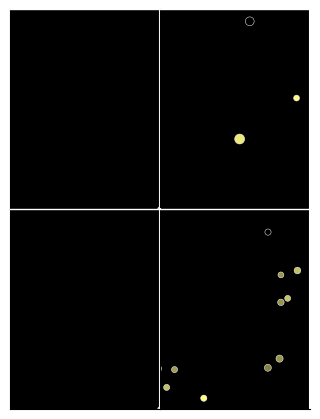

Syn15


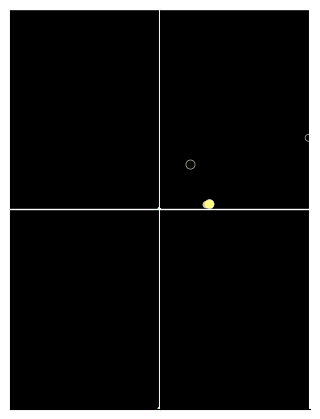

Syn16


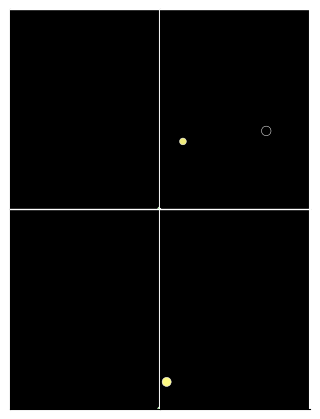

Syn1


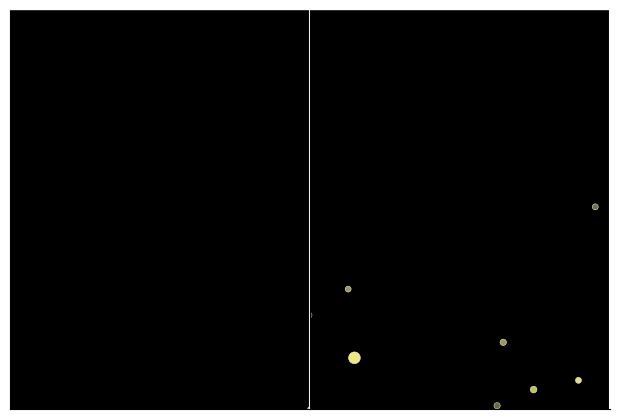

Syn6


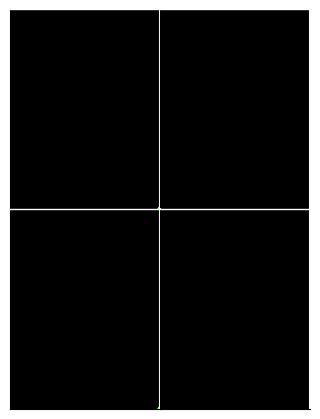

hAPP
hAPP12


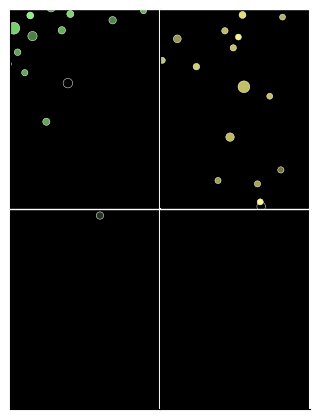

hAPP22


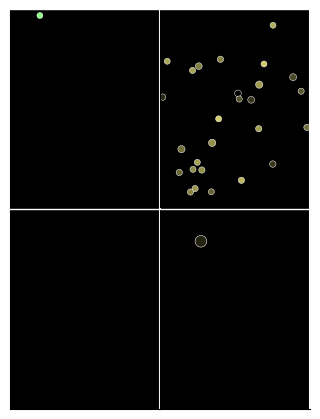

hAPP17


hAPP1


hAPP2


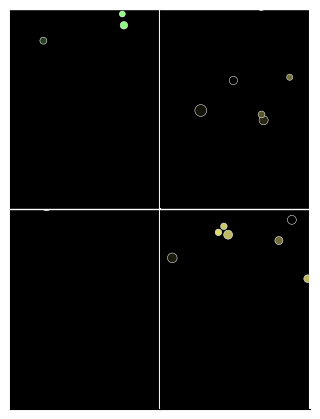

hAPP4


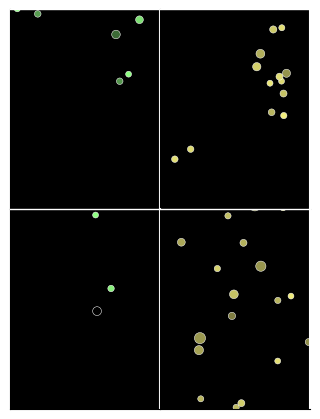

hAPP6


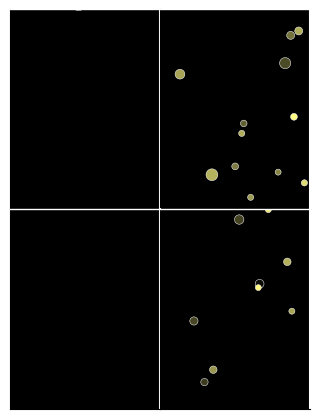

hAPP8


hAPP11


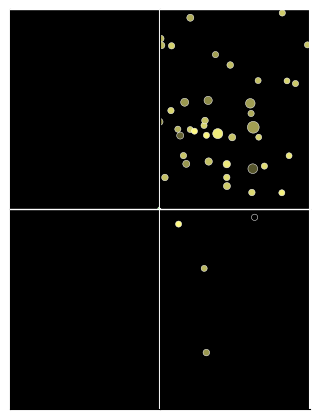

NLGF
NLGF15


NLGF16


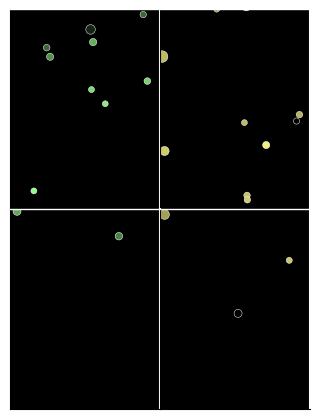

NLGF21


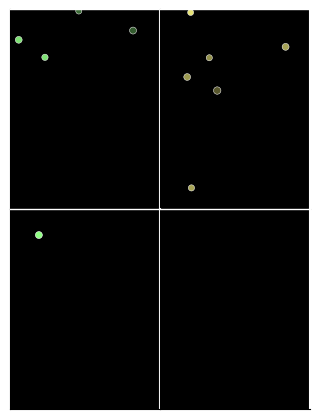

NLGF7


NLGF9


NLGF12


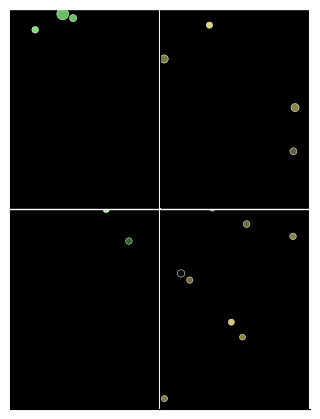

NLGF13


Syn
Syn14
Syn15
Syn16
Syn1
Syn6


hAPP
hAPP12
hAPP22
hAPP17
hAPP1
hAPP2
hAPP4
hAPP6
hAPP8
hAPP11


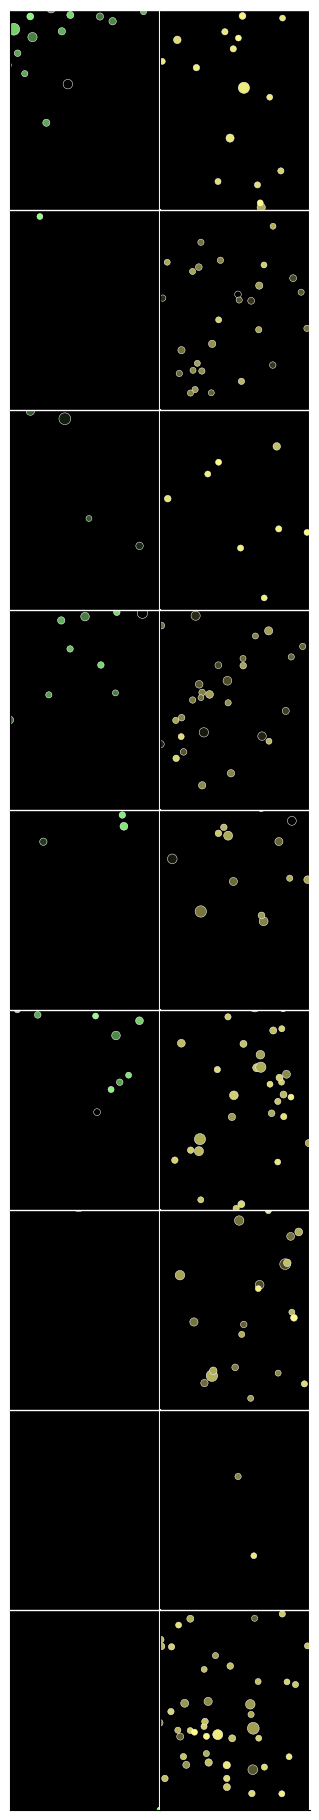

NLGF
NLGF15
NLGF16
NLGF21
NLGF7
NLGF9
NLGF12
NLGF13


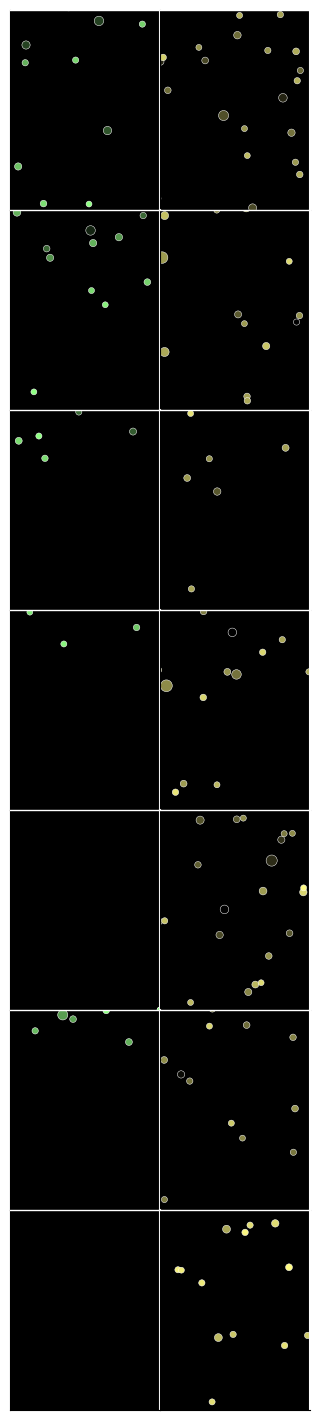

Syn
hAPP
NLGF


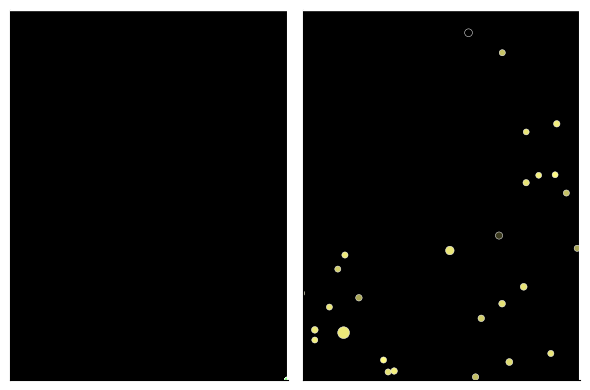

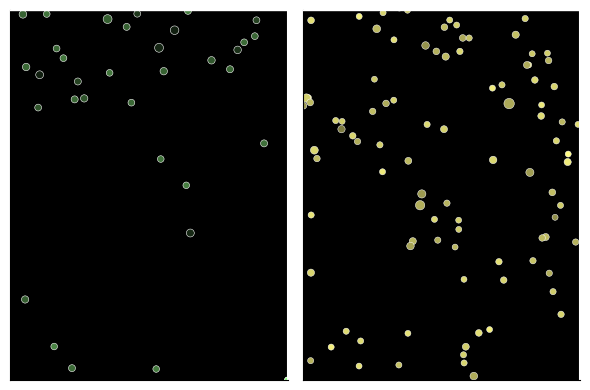

In [ ]:
#Plot Locations
def plot_locations(experiment, stain_objects):
    iterate_condition(stain_objects=stain_objects, experiment=experiment, ifunction_c=iterate_animals, ifunction_a=iterate_SCN, afunction_s_list=[scatter], s_args={'local':1}, afunction_a_list=[create_subfigure], a_args={'length':'SCN_length'}, )
    iterate_condition(stain_objects=stain_objects, experiment=experiment, ifunction_c=iterate_animals, afunction_c_list=[create_subfigure], afunction_a_list=[scatter], c_args={'length':'animal_length'}, a_args={'local':1})
    iterate_condition(stain_objects=stain_objects, experiment=experiment, afunction_c_list=[create_subfigure, scatter], c_args={'length':1},)

plot_locations(exp4, ['MOAB-2', 'H31L21'])

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

Batch in args
Including columns containing: ['AT8']
Excluding columns containing: ['Coloc', 'Group', 'XM', 'YM', 'ZM', '%']
_______________________________________________
16 AT8 Total Particle Integrated Density / micron³
'outs'
[1.7405648406503393, 17.281685144201465, 19.75699260217088]
Dataset is Not Normally distributed
P-Values are: [0.11494519807807799, 0.02916816283619292, 0.5620202534843923]
A Kruskal-Wallis test was used
The overall P-Value was: KruskalResult(statistic=4.873450292397662, pvalue=0.08744675840390113)


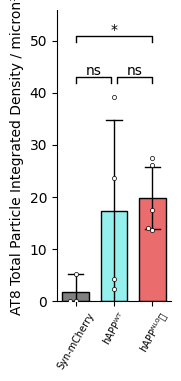

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

17 AT8 Mean Particle Integrated Density
[6004.984208333332, 14494.046811904762, 25004.226184508447]
Dataset is Not Normally distributed
P-Values are: [0.3473473358829354, 0.006651100769776905, 0.05949860132039848]
A Kruskal-Wallis test was used
The overall P-Value was: KruskalResult(statistic=8.088538011695904, pvalue=0.017522508826818647)


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

24 AT8 Count / 1000000 microns³
[0.5744050471156238, 1.805273005220532, 11.619393524510334]
Dataset is Not Normally distributed
P-Values are: [0.30268607988264207, 0.008346108027331685, 0.0894864928997076]
A Kruskal-Wallis test was used
The overall P-Value was: KruskalResult(statistic=7.420818713450295, pvalue=0.024467505283491783)


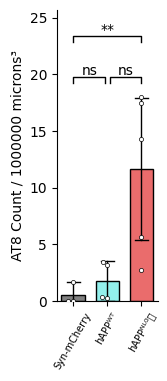

Index(['Iba1 Total Particle Integrated Density / micron³',
       'Iba1 Mean Particle Integrated Density', 'Iba1 XM', 'Iba1 YM',
       'Iba1 ZM', 'Iba1 Raw XM', 'Iba1 Raw YM',
       'Iba1 Count / 1000000 microns³',
       'MOAB-2 Total Particle Integrated Density / micron³',
       'MOAB-2 Mean Particle Integrated Density', 'MOAB-2 XM', 'MOAB-2 YM',
       'MOAB-2 ZM', 'MOAB-2 Raw XM', 'MOAB-2 Raw YM',
       'MOAB-2 %Colocalisation with mCherry',
       'MOAB-2 %Colocalisation with Iba1',
       'MOAB-2 %Colocalisation with H31L21', 'MOAB-2 Count / 1000000 microns³',
       'MOAB-2 mCherry-Colocalised Count / 1000000 microns³',
       'MOAB-2 mCherry-Non Colocalised Count / 1000000 microns³',
       'MOAB-2 Iba1-Colocalised Count / 1000000 microns³',
       'MOAB-2 Iba1-Non Colocalised Count / 1000000 microns³',
       'MOAB-2 H31L21-Colocalised Count / 1000000 microns³',
       'MOAB-2 H31L21-Non Colocalised Count / 1000000 microns³',
       'H31L21 Total Particle Integrated Densit

In [401]:
#Plot mean bars
logger.setLevel('ERROR')
def plot_mean_bars(exp):
    iterate_columns(experiment=exp, afunction_col_list=[create_subplots, plot_bars_with_points], col_args={'length':1, 'width':1, 'size':(3,5), 'included_columns':'AT8', 'excluded_columns': ['Coloc', 'Group', 'XM', 'YM', 'ZM', '%'],'Batch':1})

plot_mean_bars(exp3)
exp4.Summary.columns

In [ ]:
#Plot mean bars comparing across experiments
def plot_mean_bars_diff_experiments(exp1, attribute1, exp2, attribute2, column_list):
    #Get list of columns as dataframes for experiment 1
    #Get DFs from object class
    exp1_df = exp1.Summary
    column1_list = [f'{attribute1} {column}' for column in column_list] 
    exp1_dfs = [exp1_df[[column, 'Condition']] for column in column1_list]
    exp2_df = exp2.Summary
    column2_list = [f'{attribute2} {column}' for column in column_list] 
    exp2_dfs = [exp2_df[[column, 'Condition']] for column in column2_list]
    exp_col_dfs = [exp1_dfs, exp2_dfs]
    exp_ordered_col_dfs = [[exp_col_dfs[0][i], exp_col_dfs[1][i]] for i in range(len(column_list))]
    #Iterate through column_list
    for i,column in enumerate(column_list):
        col_dfs = exp_ordered_col_dfs[i]
        cond_dfs = [[df[df['Condition'] == condition.name] for condition in condition_list] for df in col_dfs]
        ordered_cond_dfs = flatten([[cond_dfs[0][i], cond_dfs[1][i]] for i in range(len(condition_list))])
        col_mean_list = [df.iloc[:, 0].mean() for df in ordered_cond_dfs]
        animal_mean_list = [mean for mean in [df.iloc[:, 0] for df in ordered_cond_dfs]]
        
        #Plot Bars
        fig, ax = plt.subplots(1, 1, figsize=(5,5))
        colors_list = ['grey', colors['blue'], colors['red']]
        colors_list = [i for t in zip(colors_list,colors_list) for i in t] #Doubles each element in colors_list
        x_list = [attribute1, attribute2] * len(condition_list)
        print(x_list)
        [sns.barplot(x=[j], y=[col_mean_list[j]], 
                     width=1, ax=ax, gap=0.3,
                     color=colors_list[j], edgecolor='black') 
        for j in range(len(col_mean_list))]

        #Plot points
        [sns.swarmplot(x=[j]*len(animal_mean_list[j]), y=animal_mean_list[j],
                      size=3, color='white', edgecolor='black', linewidth=0.5, 
                      ax=ax)
        for j in range(len(col_mean_list))]

        #Stats
        compare_adjacent_bars(animal_mean_list, ax)
        #Make it pretty :)
        sns.despine(trim=False)
        ax.set_xticks(range(len(col_mean_list)))
        ax.set_xticklabels(x_list, fontsize=7, rotation=60, ha='center', va='top')
        ax.set_ylabel(column)
        ax.set_ylim(ymin=0, ymax=80)
        plt.tight_layout(pad=5)
        plt.show()


plot_mean_bars_diff_experiments(exp3, 'H31L21', exp2, 'MOAB-2', ['mCherry-Colocalised Count', 'Count'])




In [454]:
#Compare across Batch

def plot_mean_over_time(exp, included_columns, excluded_columns):
    df = exp.Summary
    filtered_columns = filter_columns(df.columns.to_list(), included_columns, excluded_columns)
    cond_list = AD_condiions.total
    #df = df[filtered_columns, 'Condition']
    for i,column in enumerate(filtered_columns):
        #col_batch_dfs = [cond_df[column][cond_df['Batch'] == num] for num in [1,2] for cond_df in [df[df['Condition'] == cond.name] for cond in cond_list]]
        col_batch_dfs = [batch_df[column][batch_df['Condition'] == cond.name] for cond in cond_list for batch_df in [df[df['Batch'] == num] for num in [1,2]]]
        col_batch_means = [mean for mean in [col_df for col_df in col_batch_dfs]]
        fig, ax = plt.subplots(1,1, figsize=(3,5))
        bar_colors = list(np.repeat(cond_list, 2))

        bars = [sns.barplot(x=[j]*len(col_batch_dfs[j]), y=col_batch_means[j], 
                        width=1, ax=ax, gap=0.3,
                        color = bar_colors[j].color,
                        edgecolor='black') 
            for j in range(len(col_batch_dfs))]
        
        [sns.swarmplot(x=[j]*len(col_batch_dfs[j]), y=col_batch_means[j],
                        size=3, color='white', edgecolor='black', linewidth=0.5, 
                        ax=ax)
            for j in range(len(col_batch_dfs))]
        sns.despine(trim=False)
        #ax.set_xticks(range(len('hAPP', 'NLGF')))
        #ax.set_xticklabels([cond.label for cond in [']], fontsize=7, rotation=60, ha='center', va='top')
        plt.tight_layout(pad=5)
        plt.show()

plot_mean_over_time(exp3, 'GFAP', ['_', 'XM', 'YM', 'ZM', '%', 'Coloc'])

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

In [59]:
#Plot Matrices for a single experiment
def plot_matrices(experiment):
    iterate_condition(experiment=experiment, afunction_c_list=[create_subplots,matrices], c_args={'length':1, 'width':1, 'size':(20,15), 'columns':None, 'included_columns': 'All', 'excluded_columns':['%', 'Coloc', 'Group', 'Raw']})

plot_matrices(CK1I_exp1)

KeyError: 'separate_conditions'

INFO:__main__:Separating on Condition
INFO:__main__:Syn
INFO:__main__:['AT8 %Colocalisation with mCherry', 'AT8 Count / 1000000 microns³', 'AT8 Mean Particle Integrated Density', 'AT8 Raw XM', 'AT8 Raw YM', 'AT8 Total Particle Integrated Density / micron³', 'AT8 XM', 'AT8 YM', 'AT8 ZM', 'AT8 mCherry-Colocalised Count / 1000000 microns³', 'AT8 mCherry-Non Colocalised Count / 1000000 microns³', 'Activity onset error', 'Arrhythmic', 'Batch', 'CK1δ %Colocalisation with mCherry', 'CK1δ Count / 1000000 microns³', 'CK1δ Mean Particle Integrated Density', 'CK1δ Raw XM', 'CK1δ Raw YM', 'CK1δ Total Particle Integrated Density / micron³', 'CK1δ XM', 'CK1δ YM', 'CK1δ ZM', 'CK1δ mCherry-Colocalised Count / 1000000 microns³', 'CK1δ mCherry-Non Colocalised Count / 1000000 microns³', 'DAPI Count / 1000000 microns³', 'DAPI Count / 1000000 microns³.1', 'DAPI Mean Particle Integrated Density', 'DAPI Mean Particle Integrated Density.1', 'DAPI Raw XM', 'DAPI Raw XM.1', 'DAPI Raw YM', 'DAPI Raw YM.1', 'DAPI

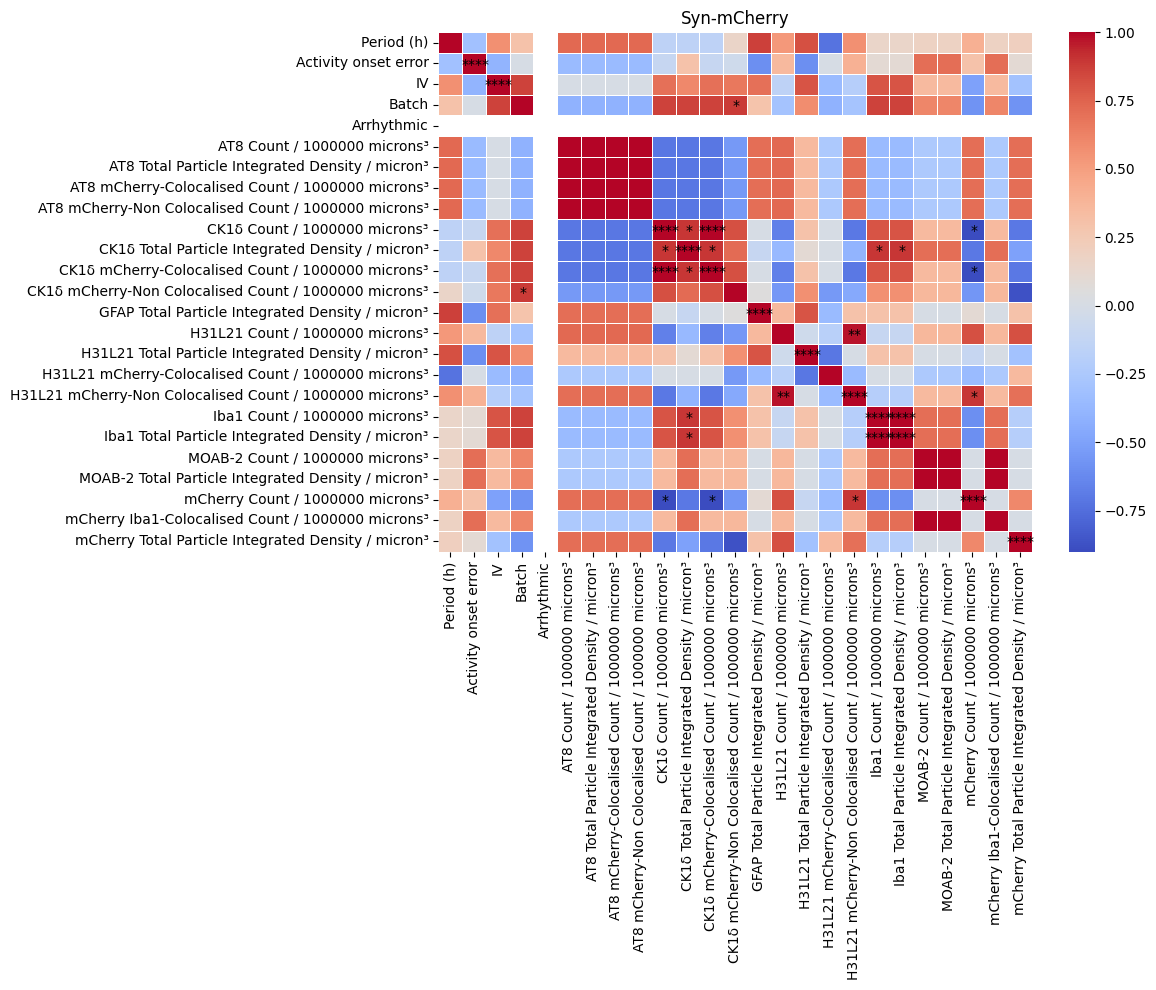

INFO:__main__:hAPP
INFO:__main__:['AT8 %Colocalisation with mCherry', 'AT8 Count / 1000000 microns³', 'AT8 Mean Particle Integrated Density', 'AT8 Raw XM', 'AT8 Raw YM', 'AT8 Total Particle Integrated Density / micron³', 'AT8 XM', 'AT8 YM', 'AT8 ZM', 'AT8 mCherry-Colocalised Count / 1000000 microns³', 'AT8 mCherry-Non Colocalised Count / 1000000 microns³', 'Activity onset error', 'Arrhythmic', 'Batch', 'CK1δ %Colocalisation with mCherry', 'CK1δ Count / 1000000 microns³', 'CK1δ Mean Particle Integrated Density', 'CK1δ Raw XM', 'CK1δ Raw YM', 'CK1δ Total Particle Integrated Density / micron³', 'CK1δ XM', 'CK1δ YM', 'CK1δ ZM', 'CK1δ mCherry-Colocalised Count / 1000000 microns³', 'CK1δ mCherry-Non Colocalised Count / 1000000 microns³', 'DAPI Count / 1000000 microns³', 'DAPI Count / 1000000 microns³.1', 'DAPI Mean Particle Integrated Density', 'DAPI Mean Particle Integrated Density.1', 'DAPI Raw XM', 'DAPI Raw XM.1', 'DAPI Raw YM', 'DAPI Raw YM.1', 'DAPI Total Particle Integrated Density / 

INFO:__main__:NLGF
INFO:__main__:['AT8 %Colocalisation with mCherry', 'AT8 Count / 1000000 microns³', 'AT8 Mean Particle Integrated Density', 'AT8 Raw XM', 'AT8 Raw YM', 'AT8 Total Particle Integrated Density / micron³', 'AT8 XM', 'AT8 YM', 'AT8 ZM', 'AT8 mCherry-Colocalised Count / 1000000 microns³', 'AT8 mCherry-Non Colocalised Count / 1000000 microns³', 'Activity onset error', 'Arrhythmic', 'Batch', 'CK1δ %Colocalisation with mCherry', 'CK1δ Count / 1000000 microns³', 'CK1δ Mean Particle Integrated Density', 'CK1δ Raw XM', 'CK1δ Raw YM', 'CK1δ Total Particle Integrated Density / micron³', 'CK1δ XM', 'CK1δ YM', 'CK1δ ZM', 'CK1δ mCherry-Colocalised Count / 1000000 microns³', 'CK1δ mCherry-Non Colocalised Count / 1000000 microns³', 'DAPI Count / 1000000 microns³', 'DAPI Count / 1000000 microns³.1', 'DAPI Mean Particle Integrated Density', 'DAPI Mean Particle Integrated Density.1', 'DAPI Raw XM', 'DAPI Raw XM.1', 'DAPI Raw YM', 'DAPI Raw YM.1', 'DAPI Total Particle Integrated Density / 

In [105]:
#Plot Matrices for combined experiment summary
logger.setLevel(logging.INFO)
def plot_matrices_global(batch, included_columns=['All'], excluded_columns=['None'], separate_conditions=False):
    
    import re
    condition_type = 'Condition'
    #summary_matrix = batch.Summary.copy()
    summary_matrix = First_Round_csv
    if separate_conditions:
        batch_condition_list = batch.condition_list.primary.total
        sec_cond_list = batch.condition_list.secondary
        sec_type = sec_cond_list.factor
        condition_type = batch.condition_list.primary.factor
        logger.info(dict(zip(summary_matrix[sec_type].unique(),sorted(list(range(summary_matrix[sec_type].nunique())), reverse=True))))
        print(logger.getEffectiveLevel())
        sec_map = dict(zip(summary_matrix[sec_type].unique(),sorted(list(range(summary_matrix[sec_type].nunique())), reverse=True)))
        summary_matrix[sec_type] = summary_matrix[sec_type].map(sec_map)
        logger.info(summary_matrix[sec_type])
    else:
        batch_condition_list = batch.condition_list.total
    logger.info(f"Separating on {condition_type}")
    for i in range(len(batch_condition_list)):
        logger.info(batch_condition_list[i].name)
        fig, ax = plt.subplots(1,1, figsize=(12, 10))
        #summary_matrix = summary_matrix.filter(regex='^((?!M$).)*$')
        column_list = summary_matrix.select_dtypes(include=[int,float]).columns.tolist()
        isummary_matrix = summary_matrix[summary_matrix[condition_type] == batch_condition_list[i].name]
        #isummary_matrix.dropna(axis=1, inplace=True)
        column_list = sorted(column_list)
        logger.info(column_list)
        try:
            isummary_matrix = isummary_matrix[column_list]
        except KeyError as k:
            error_msg = str(k)
            error_values_list = re.findall(r"'([^']*)'", error_msg)
            for error in error_values_list:
                column_list.remove(error)
            isummary_matrix = isummary_matrix[column_list]
            print(f'Columns: {error_values_list} removed as they were not in the dataframe') if i == len(batch_condition_list)-1 else None
        logger.info(f"Filtered Matrix : {isummary_matrix}")
        isummary_matrix = isummary_matrix.loc[:,~isummary_matrix.columns.duplicated()].copy()
        
        filtered_columns = filter_columns(isummary_matrix.columns.tolist(), included_columns, excluded_columns)
        for behaviour in ['Arrhythmic','Batch','IV','Activity onset error','Period (h)']:
            filtered_columns.remove(behaviour)
            filtered_columns.insert(0,behaviour)
        logger.info(f"Filtered Columns List:{ filtered_columns}")
        isummary_matrix = isummary_matrix[filtered_columns]
        logger.info(f"Filtered Matrix : {isummary_matrix}")
        correlation_matrix = isummary_matrix.corr(method='spearman')
        sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=ax)
        ax.set_title(batch_condition_list[i].label, loc='Center')
        for v,column1 in enumerate(filtered_columns):
            for j,column2 in enumerate(filtered_columns):
                indexes_todrop = isummary_matrix[column1].isna() | isummary_matrix[column2].isna()
                column1_totest = isummary_matrix[~indexes_todrop][column1]
                column2_totest = isummary_matrix[~indexes_todrop][column2]
                result = stats.spearmanr(column1_totest, column2_totest)
                p = result.pvalue
                annotation = get_annotation(p, '')
                ax.text(v+0.55,j+0.55,annotation, ha='center', va='center', fontsize=10)
        plt.tight_layout()
        plt.show()
plot_matrices_global(First_Round, separate_conditions=False, included_columns=['All'], excluded_columns=['Mean','MOAB-2 Mean IntDen','MOAB-2 IntDen','Total Count', 'SCN','Total Count', 'XM', 'YM', 'ZM', '%', 'Group', 'Raw', '.', 'DAPI', 'H31L21 I', 'H31L21 M', ' M', 'MOAB-2 H', 'MOAB-2 I', 'MOAB-2 m', 'mCherry H', 'mCherry Iba1-N', 'mCherry m'])

hAPPᵂᵀ


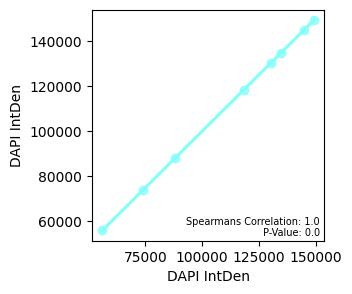

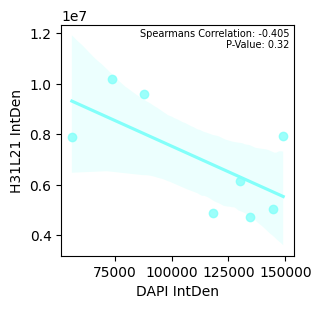

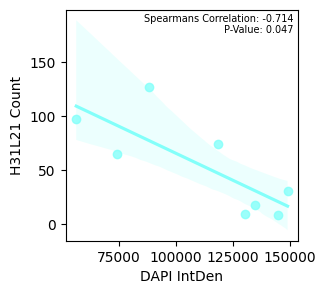

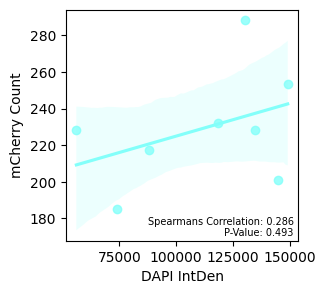

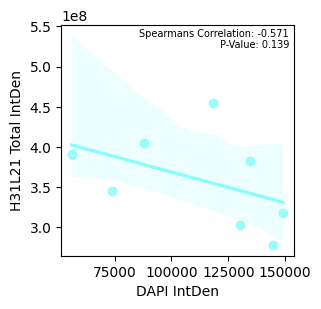

hAPPᴺᴸᴳꟳ


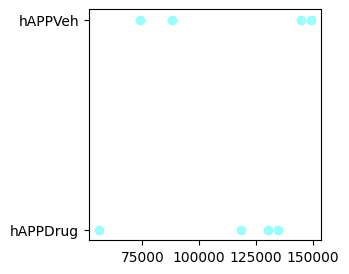

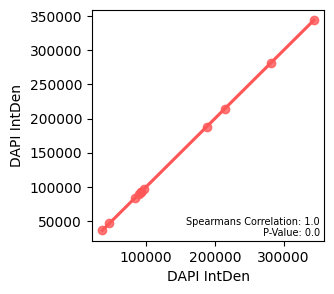

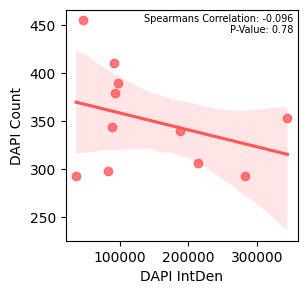

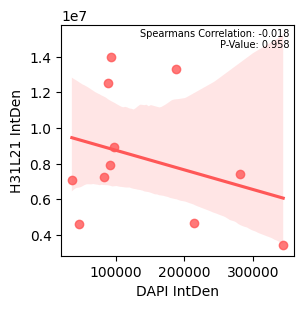

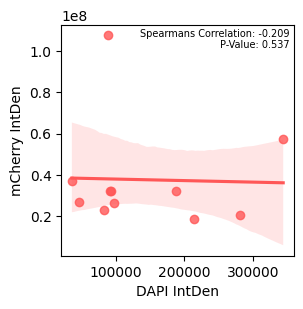

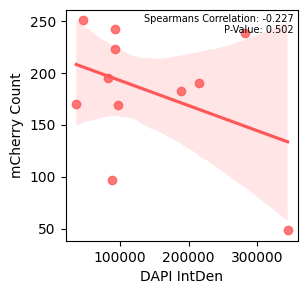

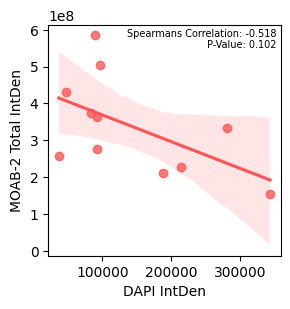

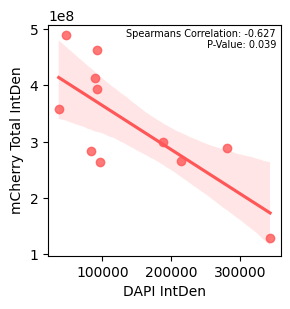

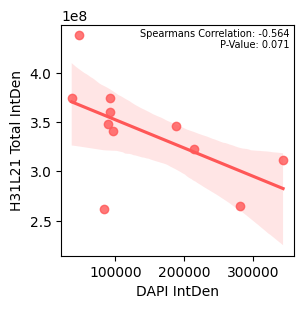

TypeError: can't multiply sequence by non-int of type 'float'

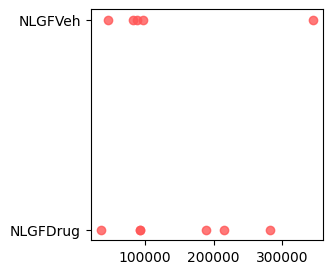

In [144]:
#Significant Scatters
def plot_significant_scatters(dfs=None, stain_objects=None, experiment=None, i=None, local_args=None, global_args=None):
    condition_type = 'Condition'
    summary_matrix = experiment.Summary
    if local_args['separate_conditions']:
        exp_cond_list = experiment.condition_list.primary.total
        sec_cond_list = experiment.condition_list.secondary
        sec_type = sec_cond_list.factor
        condition_type = experiment.condition_list.primary.factor
        sec_map = dict(zip(summary_matrix[sec_type].unique(),list(range(summary_matrix[sec_type].nunique()))))
        summary_matrix[sec_type] = summary_matrix[sec_type].map(sec_map)
    else:
         exp_cond_list = experiment.condition_list.total
    isummary_matrix = summary_matrix[summary_matrix[condition_type] == exp_cond_list[i].name]
    filtered_columns = filter_columns(summary_matrix.columns.tolist(), local_args['included_columns'], local_args['excluded_columns'])
    isummary_matrix = isummary_matrix[filtered_columns] 
    
    for v,column1 in enumerate(filtered_columns):
            for j,column2 in enumerate(filtered_columns):
                indexes_todrop = isummary_matrix[column1].isna() | isummary_matrix[column2].isna()
                column1_totest = isummary_matrix[~indexes_todrop][column1]
                column2_totest = isummary_matrix[~indexes_todrop][column2]
                result = stats.spearmanr(column1_totest, column2_totest)
                p = result.pvalue
                if True:
                    scatter_fig, scatter_ax = plt.subplots(1,1,figsize=(3,3))
                    sns.regplot(x=column1_totest, y=column2_totest, 
                                    color=exp_cond_list[i].color,
                                    ax=scatter_ax)
                    y = 0.02 if result.statistic > 0 else 0.9
                    plt.annotate(f'Spearmans Correlation: {round(result.statistic,3)}\nP-Value: {round(result.pvalue,3)}',xy=(0.98,y),xycoords='axes fraction', ha='right',fontsize=7) if local_args['annotate'] else None
                    plt.legend().set_visible(False)
                    plt.show()

iterate_condition(experiment=CK1I_exp2, afunction_c_list=[plot_significant_scatters], c_args={'length':1, 'width':1, 'size':(20,6), 'included_columns':['All'], 'excluded_columns':['Mean','MOAB-2 Count','MOAB-2 Mean IntDen','MOAB-2 IntDen','Total Count', 'SCN','Total Count', 'Coloc', 'XM', 'YM', 'ZM', '%', 'Group', 'Raw', '_'], 'separate_conditions':True, 'annotate':True})

In [ ]:
#Linear Regression Between Conditions
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

logger.setLevel('WARNING')
def plot_scatter(exp_or_batch, x_axis, y_axis, annotate=True, separate_conditions=False):
    df = exp_or_batch.Summary.copy()
    new_df = df.copy()
    if separate_conditions:
        cond_list = exp_or_batch.condition_list.secondary.total
        separator = 'Drug'
        palette = [colors['dark_blue'], colors['blue']]
    else: 
        cond_list = exp_or_batch.condition_list.total
        separator = 'Condition'
        palette = [colors['dark_blue'], colors['blue'], colors['dark_red'], colors['red']]
    cond_order = []
    cond_colors = []
    coefs = []
    #df = df[[x_axis, y_axis,'Condition', 'MOAB-2 Total Integrated Density / micron³', 'H31L21 Total Particle Integrated Density / micron³']]
    df = df.dropna(axis=0)
    scaler = StandardScaler()
    sdes = []
    coef = []
    for cond in cond_list:
        cond_order.append(cond.name)
        cond_colors.append(cond.color)
        logger.info(cond.name)
        logger.debug(df[separator])
        cond_df = df[df[separator]==cond.name]
        X = cond_df[[x_axis]]
        X = sm.add_constant(X)
        y = cond_df[y_axis]
        ols = sm.OLS(cond_df[[y_axis]], X)
        ols_result = ols.fit()
        #sdes.append(ols_result.bse[1])
        #coef.append(ols_result.params[1])
        #print(ols_result.params[1])
        #cond_df = cond_df[[x_axis, y_axis]]
        #cond_df[x_axis] = scaler.fit_transform(cond_df[[x_axis]])
        #cond_df[y_axis] = scaler.fit_transform(cond_df[[y_axis]])
        #X = cond_df[[x_axis, 'MOAB-2 Total Integrated Density / micron³', 'H31L21 Total Particle Integrated Density / micron³']]
        X = cond_df[[x_axis]]
        X = X.select_dtypes(include=['int', 'float'])
        X = scaler.fit_transform(X)
        lr = LinearRegression()
        lr.fit(X, y)
        labels = cond_df.columns.to_list()
        labelled = dict(zip(labels, lr.coef_))
        sorted_dict_asc = dict(sorted(labelled.items(), key=lambda item: abs(item[1]), reverse=True))
        print(sorted_dict_asc)    
        coefs.append(lr.coef_)
        #print(lr.coef_)
        logger.info(cond_df[x_axis])
        result = stats.pearsonr(cond_df[x_axis], cond_df[y_axis])
        #logger.info(cond_df[y_axis], cond_df[x_axis])
        p = result.pvalue
        scatter_fig, scatter_ax = plt.subplots(1,1,figsize=(3,3))
        sns.regplot(x=x_axis, y=y_axis, data=cond_df, 
                        color=colors['dark_blue'], ci=None, robust=False,
                        ax=scatter_ax)
        y = 0.02 if result.statistic > 0 else 0.9
        
        plt.annotate(f'Pearsons Correlation: {round(result.statistic,3)}\nP-Value: {round(result.pvalue,3)}',xy=(0.98,y),xycoords='axes fraction', ha='right',fontsize=7) if annotate else None
        plt.legend().set_visible(False)
        plt.show()
    #print(coefs)
    
    #print(df['Genotype'])
    #genotype_markers = list(df['Genotype'].map(markers))
    genotype_markers = {'hAPP':'^', 'NLGF':'o'}
    drug_colors = {'Drug':colors['blue'], 'Veh':colors['dark_blue']}
    hue = 'Drug' if separate_conditions else 'Condition'
    print(genotype_markers)
    g = sns.lmplot(x=x_axis, y=y_axis, data=df,
                   hue=hue, hue_order=cond_order, 
                   palette=palette, 
                   scatter=True,
                   #markers=markers, 
                   #facet_kws={'hue_kws':'Condition'}, 
                   ci=None, robust=True, n_boot = 1000000)
    #plt.show()
    if separate_conditions:
        g._legend.remove()
        for genotype, marker in genotype_markers.items():
            sns.scatterplot(
                x=x_axis, y=y_axis, data=df[df['Genotype'] == genotype],
                hue=hue, hue_order=cond_order,
                palette=drug_colors, marker=marker, ax=g.ax
        )
        
        legend_handles = [
        Line2D([0], [0], marker=genotype_markers[genotype], color='w', label=genotype,
               markerfacecolor='k', markersize=10) for genotype in genotype_markers.keys()
        ]
        legend_handles += [
        Line2D([0], [0], color=drug_colors[drug], label=drug) for drug in cond_order
        ]
        g.ax.legend(handles=legend_handles, bbox_to_anchor=(0.3,1,1,0))
    plt.show()

    fig, ax = plt.subplots(1,1, figsize=(2,3))
    print(f"X: {list(range(len(cond_list)))}")
    print(f'Coefs: {flatten(coefs)}')
    
    if False:
        Z = (coef[0] - coef[1]) / ((sdes[0])**2 + (sdes[1])**2)**0.5
        p = scipy.stats.norm.sf(abs(Z))*2
        print(Z, p)
        
        Z = (coef[2] - coef[3]) / ((sdes[2])**2 + (sdes[3])**2)**0.5
        p = scipy.stats.norm.sf(abs(Z))*2
        print(Z, p)
    
        z, p = compareCorrelations(df[df['Condition'] == 'hAPPVeh'], df[df['Condition'] == 'hAPPDrug'], coef[0], coef[1])
        #print(z,p)
    bars = sns.barplot(x=list(range(len(cond_list))), y=flatten(coefs), 
                        width=1, ax=ax, gap=0.3,
                        palette=palette, edgecolor='black')

    
    for bar in bars.patches:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2, height,  # X and Y position of the text
            f'{height:.2f}',  # The annotation text
            ha='center', va='bottom'  # Alignment of the text
        )    
    sns.despine(trim=False)
    ax.set_xticks(range(len(cond_list)))
    ax.set_xticklabels([cond.label for cond in cond_list], fontsize=7, rotation=60, ha='center', va='top')
    plt.show()
plot_scatter(CK1I, f'{CK} Count / 1000000 microns³', f'AT8 Total Integrated Density / micron³')

In [380]:
def multiple_linear_regression(exp_or_batch, features, label, scatter=False):
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import StandardScaler  
    import statsmodels.api as sm  
    df = exp_or_batch.Summary.copy()
    df = df[flatten([features, label])]
    df = df.dropna(axis=0)
    y = df[[label]]
    X = df[features]
    
    X = X.select_dtypes(include=['int', 'float'])
    features = X.columns.to_list()
    print(f'Features: {features}')
    print(f'Outcome: {label}')
    sc = StandardScaler()
    if scatter:
        fig, ax = plt.subplots(1,1,figsize=(20,2))
    cond_list = exp_or_batch.condition_list.total
    print(cond_list)
    ticks = []
    tick_labels = []
    for i,cond in enumerate(cond_list):
        if cond.name == 'Syn': continue
        ticks.append(-i)
        tick_labels.append(cond.label)
        X_cond = X[df['Condition'] == cond.name]
        y_cond = y[df['Condition'] == cond.name]
        spearmans = [stats.spearmanr(X_cond[col], y_cond) for col in X_cond.columns]
        sizes = [1-pvalue for pvalue in [spearman.pvalue for spearman in spearmans]]
        print(f'PValues: {[spearman.pvalue for spearman in spearmans]}')
        print(sizes)
        X_cond = sc.fit_transform(X_cond)
        y_cond = sc.fit_transform(y_cond)
        lr = LinearRegression()
        res = sm.OLS(y_cond, sm.add_constant(X_cond)).fit()
        print(res.summary())
        lr.fit(X_cond, y_cond)
        coef_data = pd.Series(lr.coef_[0], index=features)
        coef_df = coef_data.reset_index()
        coef_df.columns = ['Feature', 'Coefficient']
        custom_palette = {f'{CK}': 'yellow', 'MOAB-2':'yellow', 'mCherry':'red', 'AT8':'blue', 'H31L21':colors['green'], 'Iba1':colors['purple'], 'GFAP':'Magenta'}
        # Add a new column for the group
        coef_df['Group'] = coef_df['Feature'].str.split(' ').str[0]
        if not scatter:
            ax = sns.barplot(
            data=coef_df.sort_values('Coefficient',ascending=False),
            x='Coefficient',
            y='Feature',
            hue='Group',
            palette = custom_palette,
            dodge=False)
        else:
            #row = coef_df.iloc[i]
            coef_df['Marker'] = coef_df['Feature'].apply(lambda x: 'Count / 1000000 microns³' if 'Count' in x else 'Total Particle Integrated Density / microns³')
            marker_shapes = {'Count / 1000000 microns³': 'o', 'Total Particle Integrated Density / microns³': 'o'} 
            #scatter_ax = sns.scatterplot(x='Coefficient', y=i, data=coef_df, hue='Group', palette=custom_palette, markers=marker_shapes,style='Marker', size=sizes, sizes=(100,1000), ax=ax, alpha=0.5)
            for x, point in coef_df.iterrows():
                if 'Count' in point['Marker']:
                    ax.scatter(
                        x=point['Coefficient'],
                        y=i,
                        facecolors='none',  # Unfilled
                        edgecolors=custom_palette[point['Group']],
                        lw=5,
                        s=(sizes[x])*1000,
                        alpha=0.5,
                        #sizes=(10,1000)
                        #marker=point['Marker']
                    )
            for x, point in coef_df.iterrows():
                if 'Total' in point['Marker']:
                    ax.scatter(
                        x=point['Coefficient'],
                        y=i,
                        facecolors=custom_palette[point['Group']],  # Unfilled
                        edgecolors=custom_palette[point['Group']],
                        s=(sizes[x])*1000,
                        alpha=0.5,
                        #sizes=(10,1000)
                        #marker=point['Marker']
                    )
            plt.legend().set_visible(False)
    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels)
    ax.set_ylim(0,3)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_xlim(-0.5, 0.5)
    plt.show()
def add_jitter(y):
    y += np.random.normal(loc=0.0, scale=0.2, size=None)
    return y
#filtered_columns = filter_columns(CK1I.Summary.columns.to_list(), ['All'], ['mCherry','H31L21 Total In', 'Mean', 'MOAB-2 Total Particle','MOAB-2 Count', 'MOAB-2 Mean', 'AT8', 'XM', 'YM', 'ZM', '_', 'SCN', '%', 'Group', 'Coloc', 'Raw', 'DAPI', 'Total Count'])
filtered_columns = filter_columns(First_Round.Summary.columns.to_list(), ['All'], ['Iba1 Total In','CK','Batch','H31L21 Total In', 'Mean', 'MOAB-2 Mean','MOAB', 'XM', 'YM', 'ZM', 'SCN', '%', 'Group', 'Coloc', 'Raw', 'DAPI', 'Total Count', '_'])
multiple_linear_regression(First_Round, filtered_columns, 'MOAB-2 Count / 1000000 microns³', scatter=True)
print(np.random.normal(loc=0.0, scale=0.2, size=None))

TypeError: unhashable type: 'list'

In [41]:
import plotly.graph_objects as go
def ThreeD_plot(exp_or_batch, x_axis, y_axis, z_axis, size=None, color=None, colorscale=None, opacity=None):
    df = exp_or_batch.Summary.copy()
    cond_list = exp_or_batch.condition_list.total
    for cond in cond_list:
        cond_df = df[df['Condition'] == cond.name]
    hue_list = df['Condition']
    hue_list = list(map(lambda x: colors['blue'] if x == 'hAPPDrug' else colors['dark_blue'] if x == 'hAPPVeh' else colors['red'] if x == 'NLGFDrug' else colors['dark_red'], hue_list))
    # Create the 3D scatter plot


    fig = go.Figure(data=[go.Scatter3d(x=df[x_axis], y=df[y_axis], z=df[z_axis],mode='markers',marker=dict(size=size, color=hue_list, colorscale=colorscale, opacity=0.8,line=dict(width=5)))])
    

    # Set layout options for the 3D scene
    initial_camera = dict(
    eye=dict(x=1.0, y=1.0, z=1.0),  # Initial camera position (changed)
    center=dict(x=0, y=0, z=0)
    )
    fig.update_layout(scene=dict(
    camera=initial_camera,
    bgcolor='black'
    )
    )

    fig.update_layout(scene=dict(xaxis_title=x_axis, yaxis_title=y_axis, zaxis_title=z_axis,
                    xaxis = dict(nticks=0, backgroundcolor='black', showgrid=True, color='white'),
                    yaxis = dict(nticks=0, backgroundcolor='black', showgrid=True,color='white'),
                    zaxis = dict(nticks=0,backgroundcolor='black', showgrid=True,color='white'),),
    width=1000, height=1000)

    # Add frames for rotation
    frames = []
    n_frames = 720 # Number of frames (360 degrees / 10 degrees per frame)
    for i in range(n_frames):
        camera = dict(
            eye=dict(
                x=2.2* np.cos(i * 0.5 * np.pi / 180),
                y=2.2* np.sin(i * 0.5* np.pi / 180),
                z=0.5
            ),
            center=dict(x=0, y=0, z=-0.2)
        )
        frame = dict(
            name=str(i),
            layout=dict(scene=dict(camera=camera))
        )
        frames.append(frame)

    # Add animation
    fig.frames = frames
    fig.update_layout(updatemenus=[dict(type="buttons", buttons=[dict(label="Play", method="animate", args=[None, {"frame": {"duration": 20, "redraw": True}, "fromcurrent": True}])])])


    fig.show()

ThreeD_plot(CK1I, 'MOAB-2 Total Integrated Density / micron³', f'{CK} Total Integrated Density / micron³','AT8 Total Integrated Density / micron³' )

In [108]:
#Pairplot
logger.setLevel('INFO')
def pairplot(batch, included_columns=['All'], excluded_columns=['None'], separate_conditions=False):
    condition_type = 'Condition'
    df = batch.Summary.copy()
    if separate_conditions:
        batch_condition_list = batch.condition_list.primary.total
        sec_cond_list = batch.condition_list.secondary
        sec_type = sec_cond_list.factor
        condition_type = batch.condition_list.primary.factor
        sec_map = dict(zip(df[sec_type].unique(),sorted(list(range(df[sec_type].nunique())), reverse=True)))
        logger.info(sec_map)
        df[sec_type] = df[sec_type].map(sec_map)
        logger.info(df[sec_type])
    else:
        batch_condition_list = batch.condition_list.total
    logger.info(f"Included columns: {included_columns}")
    logger.info(f"Excluded columns: {excluded_columns}")
    filtered_columns = filter_columns(df.columns.tolist(), included_columns, excluded_columns)
    filtered_columns = sorted(filtered_columns)
    logger.info(f'Separating on {condition_type}')
    for cond in batch_condition_list:
        print(cond.label)
        cond_df = df[df[condition_type]==cond.name]
        cond_df = cond_df[filtered_columns]
        if separate_conditions:
            logger.info(f'Hue by {sec_type}')
            plot = sns.pairplot(cond_df, hue=sec_type)
        else: plot = sns.pairplot(cond_df)
        plt.show()
    
    

pairplot(CK1I, separate_conditions=False, included_columns=['All'], excluded_columns=['Mean','MOAB-2 Count','MOAB-2 Mean IntDen','MOAB-2 IntDen','Total Count', 'SCN','Total Count', 'Coloc', 'XM', 'YM', 'ZM', '%', 'Group', 'Raw', '_', 'AT8 Count'])

INFO:__main__:Included columns: ['All']
INFO:__main__:Excluded columns: ['Mean', 'MOAB-2 Count', 'MOAB-2 Mean IntDen', 'MOAB-2 IntDen', 'Total Count', 'SCN', 'Total Count', 'Coloc', 'XM', 'YM', 'ZM', '%', 'Group', 'Raw', '_', 'AT8 Count']
INFO:__main__:Separating on Condition


hAPPᵂᵀ + Vehicle


hAPPᵂᵀ + PF-670462


hAPPᴺᴸᴳꟳ + Vehicle


hAPPᴺᴸᴳꟳ + PF-670462


In [ ]:
#Colocalisation Bars
def plot_colocalised_bars(stain_objects, colocalisers, experiment, functions_columns_dict):
    condition_list = [hAPP, NLGF]
    labels = ['Colocalised', 'Non-Colocalised', 'Partial']
    lower_threshold = 10
    for s_o in stain_objects:
        df = experiment.data[f'{s_o}'].df
        c_dfs = [df[df[f'{s_o} %Colocalisation with {colocaliser}'] > threshold] for colocaliser in colocalisers]
        nc_dfs = [df[df[f'{s_o} %Colocalisation with {colocaliser}'] < lower_threshold] for colocaliser in colocalisers]
        p_dfs = [df[(df[f'{s_o} %Colocalisation with {colocaliser}'] > lower_threshold) & (df[f'{s_o} %Colocalisation with {colocaliser}'] < threshold)] for colocaliser in colocalisers]
        for j,df in enumerate(c_dfs):
            c_df = df
            nc_df = nc_dfs[j]
            p_df = p_dfs[j]
            for v,function_column in enumerate(functions_columns_dict.items()):
                function = function_column[1]
                column = f'{s_o} {function_column[0]}'
                fig, ax = plt.subplots(figsize=(3,3))
                calculated_c_dfs = [function(c_df[c_df['Condition'] == condition.name][column]) for condition in condition_list]
                calculated_nc_dfs = [function(nc_df[nc_df['Condition'] == condition.name][column]) for condition in condition_list]
                calculated_p_dfs = [function(p_df[p_df['Condition'] == condition.name][column]) for condition in condition_list]
                bar_data = [calculated_c_dfs, calculated_nc_dfs, calculated_p_dfs]
                print(f'{s_o} Colocalised with {colocalisers[j]} {column.split(" ")[1]}')
                for x,cond_data in enumerate(bar_data):
                    sns.barplot(x=[x*2,x*2+1], y=[cond_data[0],cond_data[1]], color=condition_list[x].color, ax=ax, width=0.5, label=labels[x])
                    ax.axvline((x*2)+1.5, ls='dashed', lw=1, color='black')
                    ax.set_xticklabels([cond.label for cond in condition_list]*3)
                    ax.legend(fontsize=5, loc=1, bbox_to_anchor=(0.27, 0, 1.1, 1.02), frameon=False)
                plt.show()
#plot_colocalised_bars(['H31L21'],['mCherry', 'MOAB-2', 'Iba1'], exp4, {'Count': len, 'Mean IntDen':np.mean})
plot_colocalised_bars([f'H31L21'], ['MOAB-2'], exp4, {'Count':len, 'Volume':np.mean})

H31L21 Colocalised with MOAB-2 Count


H31L21 Colocalised with MOAB-2 Volume


TypeError: Can only merge Series or DataFrame objects, a <class 'NoneType'> was passed

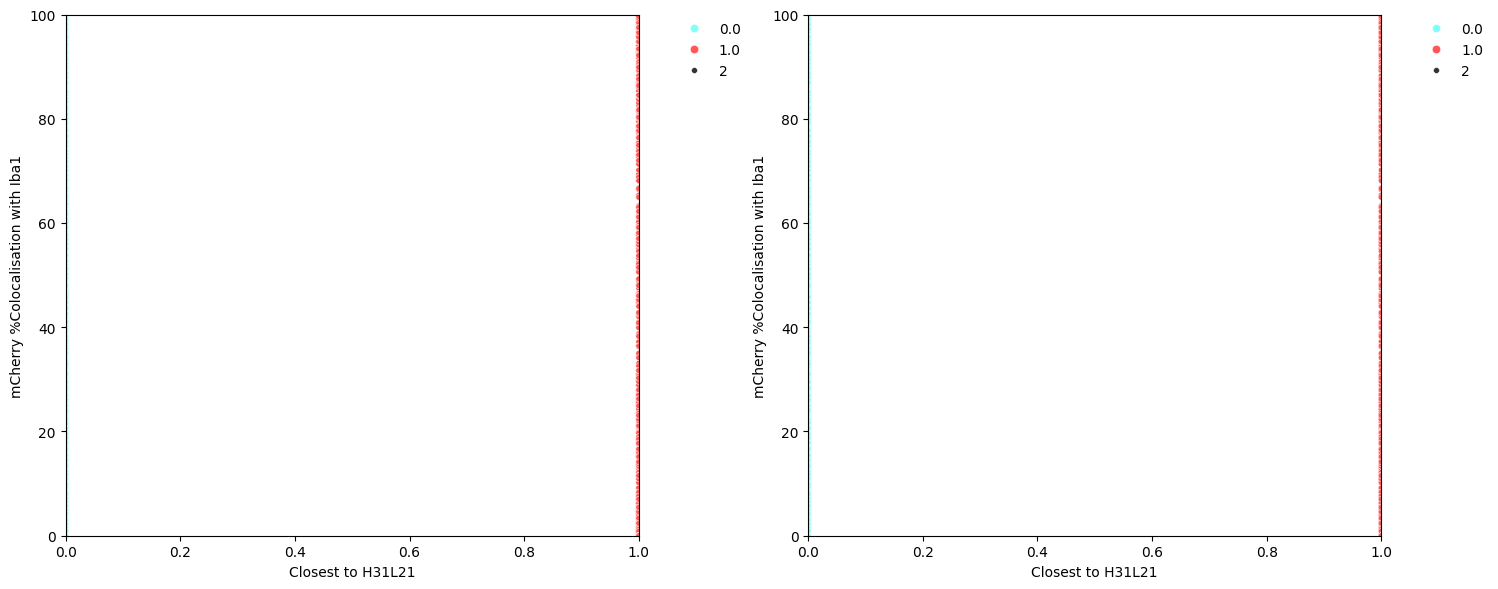

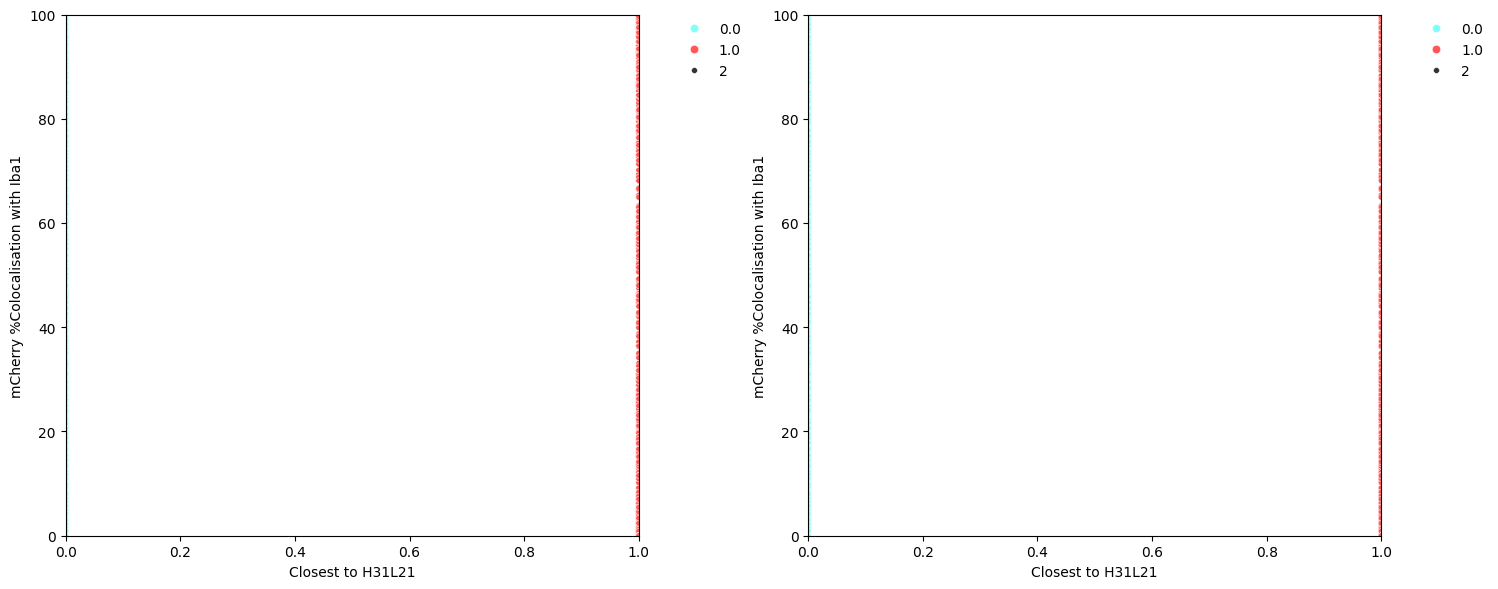

In [ ]:
#Colocalisation Distribution Scatters with clustering
Batch = pd.read_csv(f'{directory}/ImageJ/Experiments/Exp4_Iba1/Data Analysis/Batch.csv')
def plot_clusters(experiment, stain_objects):
    dfs = [experiment.data[s_o].df for s_o in stain_objects]
    fig, ax = plt.subplots(1,2, figsize=(15,6))
    for i,df in enumerate(dfs):
        stain_object = stain_objects[i]
        df = df[df['Condition'] != 'Syn']
        df = df.merge(Batch, left_on='Animal Name', right_on='Animal Name')
        cluster_df, outlier_df = create_clusters(df, stain_object)
        sns.scatterplot(x=f'{stain_object} %Colocalisation with mCherry', y=f'{stain_object} %Colocalisation with Iba1', palette=palettes['blue-red'], hue=f'Cluster',size=2, data=cluster_df, ax=ax[i])
        sns.scatterplot(x=f'{stain_object} %Colocalisation with mCherry', y=f'{stain_object} %Colocalisation with Iba1', c='k',marker='x', data=outlier_df, label='outliers',ax=ax[i])
    for ax in ax:
        ax.legend(fontsize=10, loc=1, bbox_to_anchor=(0.1, 0, 1.1, 1.01), frameon=False)
        ax.set_ylim(ymin=0, ymax=100)
        ax.set_xlim(xmin=0, xmax=100)
    plt.tight_layout()
    return cluster_df
#%pip install scikit-learn
from sklearn.cluster import DBSCAN
def create_clusters(df, stain_name, eps=17, min_points=5):
    df[f'{stain_name} Mean IntDen_normed'] = (df[f'{stain_name} Mean IntDen'] - max(df[f'{stain_name} Mean IntDen']))/(max(df[f'{stain_name} Mean IntDen'])-min(df[f'{stain_name} Mean IntDen']))*100
    X_train = df[[f'{stain_name} %Colocalisation with mCherry', f'{stain_name} %Colocalisation with Iba1']]
    #print(X_train)
    clustering = DBSCAN(eps=eps, min_samples=min_points).fit(X_train)
    #clustering = HDBSCAN(min_cluster_size=min_points, cluster_selection_epsilon=10).fit(X_train)
    #print(clustering)
    DBSCAN_dataset = X_train.copy()
    DBSCAN_dataset.loc[:,'Cluster'] = clustering.labels_ 
    #print(DBSCAN_dataset)
    outliers = DBSCAN_dataset[DBSCAN_dataset['Cluster']==-1]
    data = DBSCAN_dataset[DBSCAN_dataset['Cluster']!=-1]
    data['Cluster'] = 'Cluster ' + (data['Cluster']+1).astype('str')
    return data,outliers

clusters = plot_clusters(exp4, ['MOAB-2', 'H31L21'])
plot_clusters(exp2, [f'MOAB-2', f'MOAB-2'])
clusters
cluster_df = exp4.data['H31L21'].df.merge(clusters)
cluster_df = pd.merge(cluster_df,pd.get_dummies(cluster_df['Cluster'], dtype=int), left_index=True, right_index=True)
cluster_df.groupby('Animal Name')[['Cluster 1', 'Cluster 2', 'Cluster 3']].sum()
for cluster in ['Cluster 1', 'Cluster 2', 'Cluster 3']:
    cluster_df = cluster_df.join(cluster_df[cluster_df[cluster] == 1].groupby('Animal Name')['H31L21 IntDen'].mean(), on='Animal Name', rsuffix=f' {cluster}')
    cluster_df = cluster_df.join(cluster_df[cluster_df[cluster] == 1].groupby('Animal Name')['H31L21 Mean IntDen'].mean(), on='Animal Name', rsuffix=f' {cluster}')
cluster_df = cluster_df.join(cluster_df.groupby('Animal Name')[['Cluster 1', 'Cluster 2', 'Cluster 3']].sum(), on='Animal Name', rsuffix=' Count')
cluster_columns = cluster_df.filter(regex='Cluster').columns.tolist()
[cluster_columns.pop(0) for i in range(4)]
cluster_df_animal = cluster_df.groupby('Animal Name')[cluster_columns].mean()
cluster_df_animal
cluster_df_animal.to_csv(f'{directory}/clusters.csv')
#exp4.data['H31L21'].df


In [ ]:
#Colocalisation Distribution Scatters no clustering
def plot_dists(experiment, stain_objects, x, y):
    dfs = [experiment.data[s_o].df for s_o in stain_objects]
    fig, ax = plt.subplots(1,2, figsize=(15,6))
    for i,df in enumerate(dfs):
        stain_object = stain_objects[i]
        df = df[df['Condition'] != 'Syn']
        #df = df.merge(Batch, left_on='Animal Name', right_on='Animal Name')
        sns.scatterplot(x=f'{stain_object} {x}', y=f'{y}', palette=palettes['blue-red'], hue=f'{CK} Mean IntDen',size=f'{CK} Volume', data=df, ax=ax[i])
    for ax in ax:
        ax.legend(fontsize=10, loc=1, bbox_to_anchor=(0.1, 0, 1.1, 1.01), frameon=False)
        ax.set_ylim(ymin=-10, ymax=100)
        ax.set_xlim(xmin=-10, xmax=100)
    plt.tight_layout()
    plt.show()

plot_dists(exp2, [f'{CK}', f'{CK}'], '%Colocalisation with mCherry', f'Distance to closest MOAB-2')


In [ ]:
#Colocalisation Distribution Scatters per animal no clustering
fig, ax = plt.subplots(1,2, figsize=(10,6))
MOAB_df = exp4.data['MOAB-2'].df
MOAB_df = MOAB_df[MOAB_df['Condition']!='Syn']
H31L21_df = exp4.data['H31L21'].df
H31L21_df = H31L21_df[H31L21_df['Condition']!='Syn']
animal_list = MOAB_df['Animal Name'].unique().tolist()
for animal in animal_list:
    print(animal)
    fig, ax = plt.subplots(1,2,figsize=(10,6))
    #sns.scatterplot(x='MOAB-2 %Colocalisation with mCherry', y='MOAB-2 %Colocalisation with Iba1', c=colors['green'], data=exp4.data['MOAB-2'].df, ax=ax[0])
    sns.scatterplot(x='MOAB-2 %Colocalisation with mCherry', y='MOAB-2 %Colocalisation with Iba1', palette=palettes['blue-red'], hue='MOAB-2 Volume', data=MOAB_df[MOAB_df['Animal Name']==animal], ax=ax[0])
    #sns.scatterplot(x='H31L21 %Colocalisation with mCherry', y='H31L21 %Colocalisation with Iba1', c=colors['yellow'], data=exp4.data['H31L21'].df, ax=ax[1])
    sns.scatterplot(x='H31L21 %Colocalisation with mCherry', y='H31L21 %Colocalisation with Iba1', palette=palettes['blue-red'], hue='H31L21 IntDen', hue_norm=(0,70000000,75000000), data=H31L21_df[H31L21_df['Animal Name']==animal], ax=ax[1])
    #plt.legend().set_visible(False)
    for ax in ax:
        ax.set_ylim(ymin=0, ymax=100)
        ax.set_xlim(xmin=0, xmax=100)
    plt.show()

mCherry %Colocalisation with Iba1


mCherry %Colocalisation with H31L21


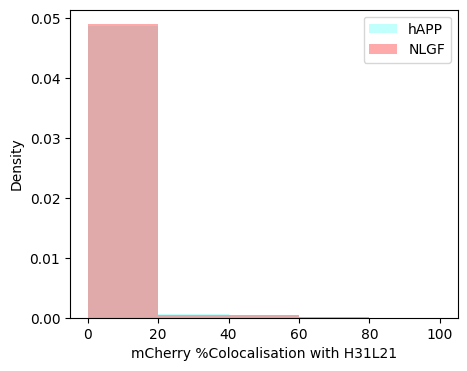

MOAB-2 %Colocalisation with Iba1


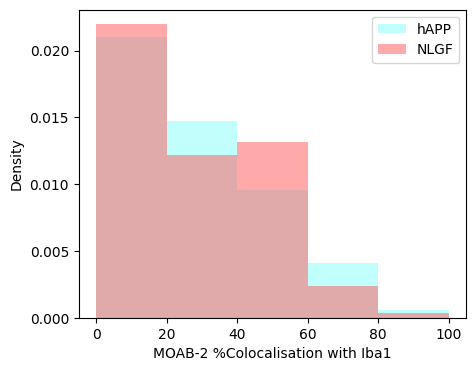

MOAB-2 %Colocalisation with H31L21


In [ ]:
#Colocalised Histograms
def plot_colocalisation_histogram(experiment, stain_objects, attributes):
    for s_o in stain_objects:
        df = experiment.data[s_o].df
        for attribute in attributes:
            cond_dfs = [df[df['Condition'] ==  condition.name] for condition in condition_list]
            fig, ax = plt.subplots(1,1, figsize=(5,4))
            print(f'{s_o} {attribute}')
            [sns.histplot(cond_dfs[i][f'{s_o} {attribute}'], ax=ax, color=cond.color, alpha=0.5, edgecolor=None, stat='density',bins=[0,20,40,60,80,100], label=cond.label) for i,cond in enumerate(condition_list)]
            plt.legend()
            plt.show()

#plot_colocalisation_histogram(exp4, ['H31L21'], ['%Colocalisation with MOAB-2'])
plot_colocalisation_histogram(exp4, [f'mCherry', 'MOAB-2'], ['%Colocalisation with Iba1', '%Colocalisation with H31L21'])        

H31L21 closest distance to mCherry


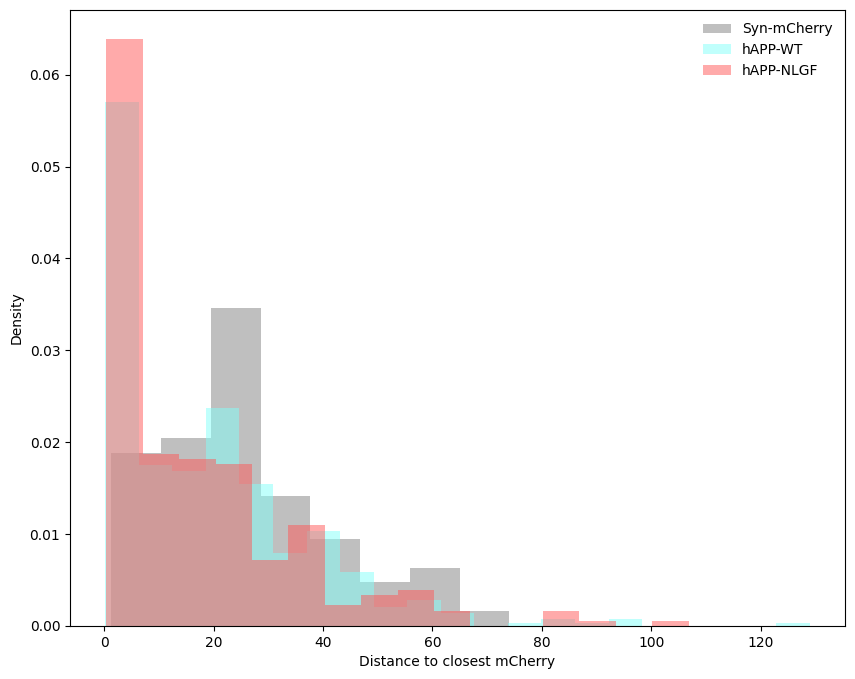

MOAB-2 closest distance to mCherry


In [ ]:
#Distance Distributions
def plot_dist_distributions(exp, stain1_list, stain2_list, stain_condition=None):
    stain1_dfs = [exp.data[stain1].df for stain1 in stain1_list]
    for i,stain1_df in enumerate(stain1_dfs):
        stain_1_cond_dfs = [stain1_df[stain1_df['Condition'] == condition.name] for condition in condition_list]
        for stain2 in stain2_list:
            fig, ax = plt.subplots(1, 1, figsize=(10,8))
            print(f'{exp.data[stain1_list[i]].name} closest distance to {stain2}')
            [sns.histplot(stain_1_cond_dfs[j][f'Distance to closest {stain2}'], color=cond.color, ax=ax, edgecolor=None, stat='density', alpha=0.5, label=cond.label) for j,cond in enumerate(condition_list)]
            legend = plt.legend(edgecolor=None)
            frame = legend.get_frame()
            frame.set_edgecolor('w')
            plt.show()

plot_dist_distributions(exp4, ['H31L21', 'MOAB-2'], ['mCherry'])